In [583]:
# from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
from slab import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename

# Fit functions

In [713]:
def coherent_state(n, a, alpha):
    return a*np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    N = 10
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def fitgausssum_with_baseline(xdata,ydata,N=10,fitparams=None,domain=None,showfit=False,
                              showstartfit=False,label="",debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:
        fitparams=0*ones(3*N+1)
        fitparams[0]=(fitdatay[0]+fitdatay[-1])/2.
        fitparams[1]=max(fitdatay)-min(fitdatay)
        fitparams[2]=fitdatax[np.argmax(fitdatay)]
        fitparams[3]=(max(fitdatax)-min(fitdatax))/10.
    if debug==True: print(fitparams)
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    p1[3]=abs(p1[3])
    return p1

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# Opt Pulse Generation

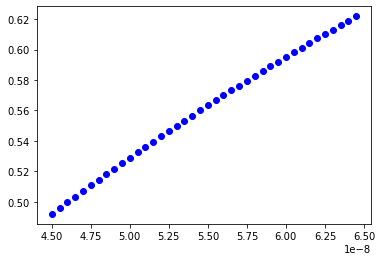

In [678]:
cav_freq = 0 #cavity frequency

Q = 8440 #cavity quality factor
kappa= (8.05183773e9)/Q
read_width = 600e-9 #readout length  in (seconds)
dt = 1e-9
n_points = int(read_width/dt)
#print(n_points)
pad_factor=10
t = dt*np.arange(0,n_points*pad_factor)
ifreq = np.fft.fftfreq(n_points*pad_factor,dt)
freq = np.fft.fftshift(ifreq)
if_band = IF_window([cav_freq,250e6],freq)
twochi = 380e3
pulse_len = 1/twochi

sigarray = np.arange(45e-9, 65e-9, 0.5e-9)
ratio = []

n_points = int(read_width/dt)
#print(n_points)
pad_factor=10
t = dt*np.arange(0,n_points*pad_factor)

for sig in sigarray:
    desired_output = erf_t(1, sig, pulse_len, 1500e-9, t)

    desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
    desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

    lorenz_c = cav_response_new([cav_freq,kappa],freq)

    input_sfft = (desired_output_sfft/lorenz_c)*if_band

    output_sfft = input_sfft*lorenz_c
    output_fft = np.fft.ifftshift(output_sfft)
    output_pulse = np.fft.ifft(output_sfft)

    input_fft= np.fft.ifftshift(input_sfft)
    input_pulse = np.fft.ifft(input_fft)
    flip=input_pulse[::-1]

    opt_pulse = np.real(flip)
    
    max_opt = np.max(opt_pulse)
    mid_opt = opt_pulse[int(len(opt_pulse)/2)]
    
    ratio.append(mid_opt/max_opt)

plt.figure()
plt.plot(sigarray,ratio, 'bo')
plt.show()

In [683]:
ratio_targ = [0.65]
ratio=np.array(ratio)
ind_list = []
for rat in ratio_targ:
    index = np.argmin(abs(ratio-rat))
    ind_list.append(index)
    
ind_list = np.array(ind_list)
print(sigarray[ind_list])

[6.45e-08]


Text(0.5, 1.0, 'Input Pulse')

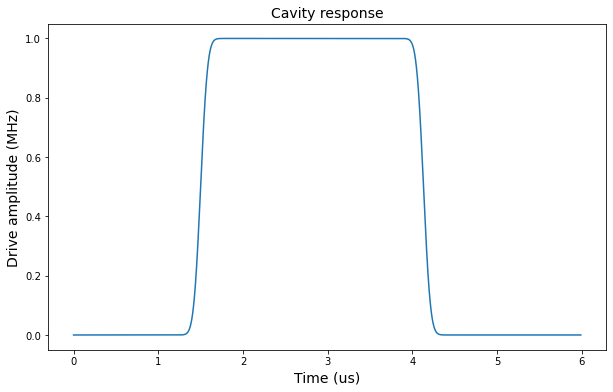

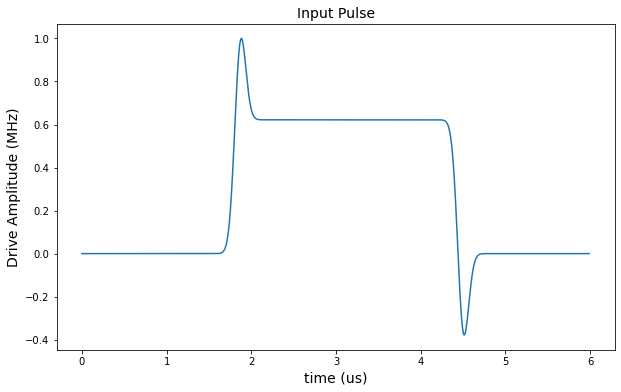

In [684]:
cav_freq = 0 #cavity frequency

Q = 8440 #cavity quality factor
kappa= (8.05183773e9)/Q
read_width = 600e-9 #readout length  in (seconds)
dt = 1e-9
n_points = int(read_width/dt)
#print(n_points)
pad_factor=10
t = dt*np.arange(0,n_points*pad_factor)
ifreq = np.fft.fftfreq(n_points*pad_factor,dt)
freq = np.fft.fftshift(ifreq)
if_band = IF_window([cav_freq,250e6],freq)
twochi = 380e3
pulse_len = 1/twochi

desired_output = erf_t(1, 6.45e-8, pulse_len, 1500e-9, t)

#Plot Desired Output
figure(figsize = (10,6))
plot(t*1e6, desired_output)
xlabel('Time (us)', fontsize =14)
ylabel('Drive amplitude (MHz)', fontsize =14)
title('Cavity response', fontsize =14)

#Generate Opt Input Pulse
desired_output_ifft = np.fft.fft(desired_output,n_points*pad_factor)/n_points
desired_output_sfft = np.fft.fftshift(desired_output_ifft) #"sfft" denotes shifted spectrum to center at cav_freq

lorenz_c = cav_response_new([cav_freq,kappa],freq)
lorenz_g = cav_response_new([cav_freq+0.2e6,Q],freq)
lorenz_e = cav_response_new([cav_freq-0.2e6,Q],freq)
lorenz= (lorenz_g*lorenz_e)

input_sfft = (desired_output_sfft/lorenz_c)*if_band

output_sfft = input_sfft*lorenz_c
output_fft = np.fft.ifftshift(output_sfft)
output_pulse = np.fft.ifft(output_sfft)

input_fft= np.fft.ifftshift(input_sfft)
input_pulse = np.fft.ifft(input_fft)
flip=input_pulse[::-1]

opt_pulse = np.real(flip)
opt_pulse = opt_pulse/np.max(opt_pulse)
#print(np.max(flip))

#Plot Generated Input Pulse
figure(figsize = (10,6))
plot(t*1.0e6,opt_pulse)
#plot(t*1.0e6,opt_pulse_im)
xlabel("time (us)", fontsize = 14)
ylabel("Drive Amplitude (MHz)", fontsize = 14)
title('Input Pulse', fontsize = 14)

## Trim Opt Pulse

In [685]:
#Find Desired Range
result1 = np.where(opt_pulse > 0.00001)
result2=np.where(opt_pulse < -0.00001)

#Trim Pulse
start_trim=result1[0][0]
end_trim=result2[0][len(result2[0])-1]
numb= end_trim - start_trim  
rem= numb % 4

#Check Total Length is Multiple of 4 for AWG
trim_pulse=opt_pulse[start_trim:end_trim - rem]
check = len(trim_pulse) % 4
print(check)

# Plot Final Pulse Shape
# plt.plot(t[0:len(trim_pulse)]*1.0e6,trim_stand_clear)
# print(trim_pulse)

0


## Save Opt Pulse Shape

In [686]:
path = os.getcwd()
data_path = os.path.join(path, "../pulses/")
seq_data_file = os.path.join(data_path,
                             get_next_filename(data_path, 'readout_optimal_pulse', suffix='.h5'))
print(seq_data_file)
with File(seq_data_file, 'w') as f:
    f.create_dataset("I_wf", data=trim_pulse)

C:\_Lib\python\slab\experiments\qm_opx\jupyter_notebooks\../pulses/00020_readout_optimal_pulse.h5


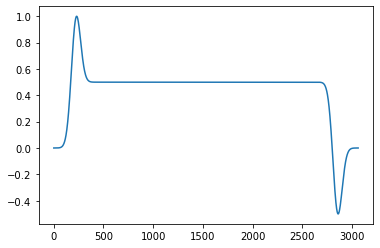

In [594]:
for i in [10]:
    opt_readout = "C:\\_Lib\\python\\slab\\experiments\\qm_opx\\pulses\\000{}_readout_optimal_pulse.h5".format(i)
    with File(opt_readout,'r') as a:
        opt_amp = np.array(a['I_wf'])
    opt_len = len(opt_amp)
    plt.figure()
    plt.plot(opt_amp)

# Resonator spectroscopy

fits =  [-7.22626340e-07  7.37545529e-04  8.05183773e+00  4.77002479e-04]
fits =  [-1.78815651e-07  4.35926405e-05  8.05184732e+00  4.98328367e-04]


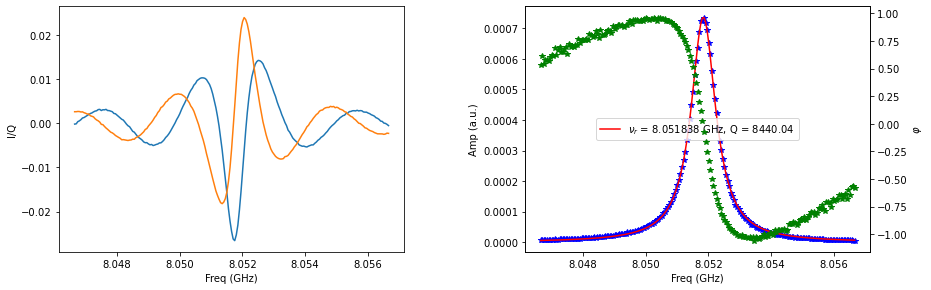

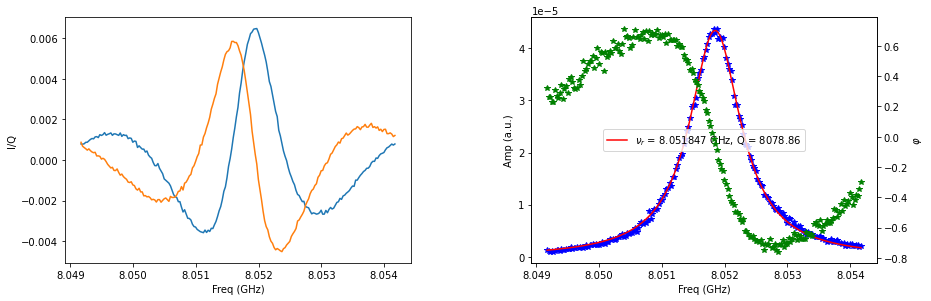

In [730]:
expt_name = 'resonator_spec'
filelist = [0, 47]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

fits =  [-1.25324606e-06  8.62685110e-05  8.05184589e+00  4.76398077e-04]
fits =  [-2.42234827e-09  8.75949477e-07  8.05184960e+00  4.58877307e-04]
fits =  [-8.45579797e-11  9.15912119e-07  8.05185353e+00  4.79274176e-04]


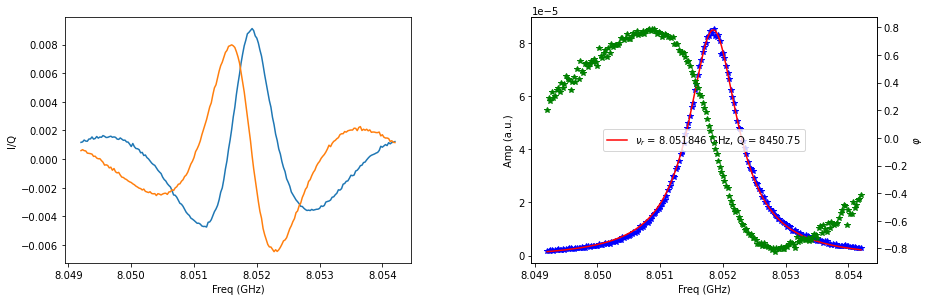

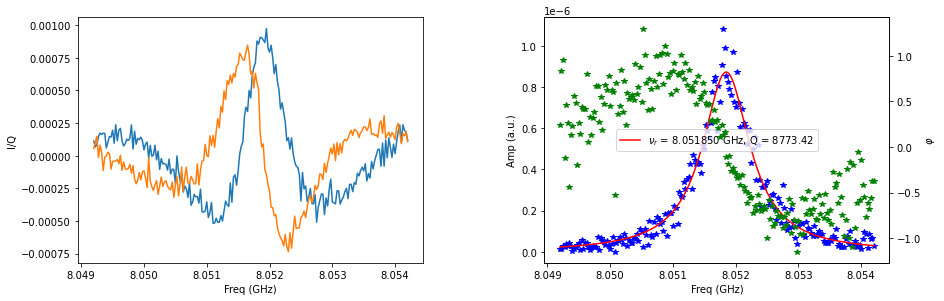

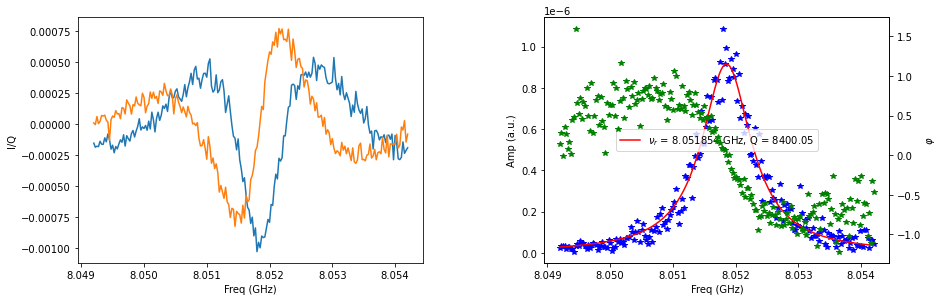

In [44]:
expt_name = 'resonator_spec_opt'
filelist = [0, 1, 2]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')

    amps = Q**2 + I**2
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b*')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'g*')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='center')

(201, 26)


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


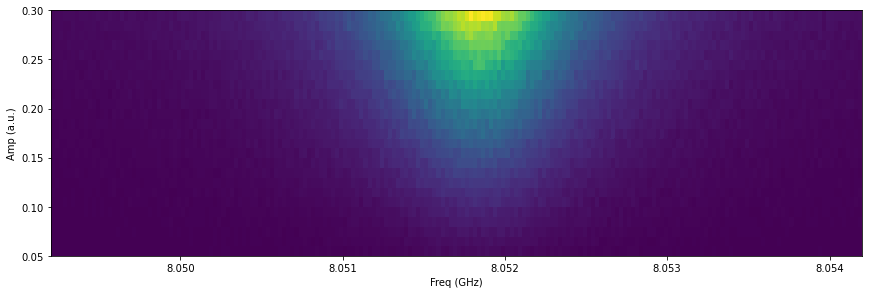

(41, 13)


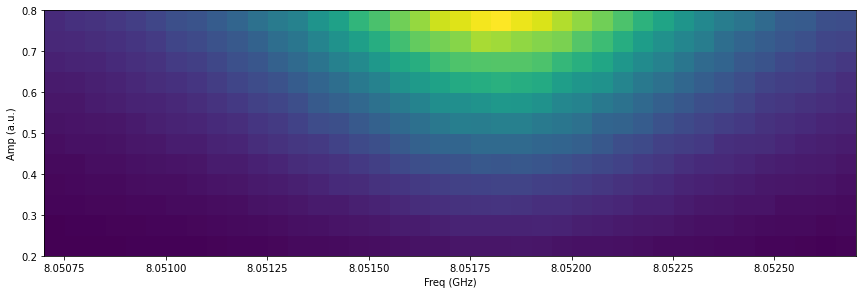

(41, 13)


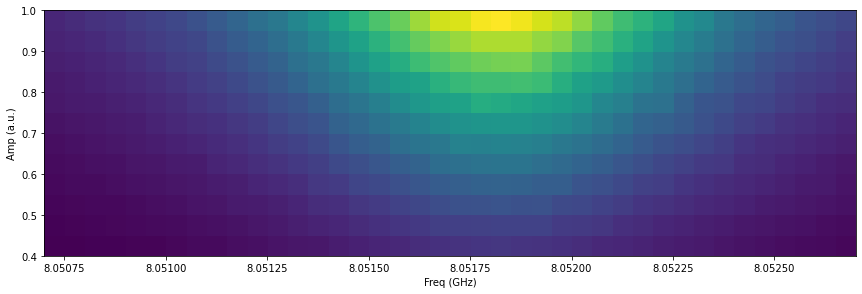

In [63]:
expt_name = 'resonator_spec_opt_power'
filelist = [1, 2, 3]
#3 - amp(0.5)
#4 - 8us long readout

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        y = array(a['amps'])
        a.close()
                
    print(np.shape(I))
    fig, axs = plt.subplots(1, 1, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    amps = np.transpose(Q**2 + I**2)
#     ph = np.arctan2(np.array(Q), np.array(I))
#     ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
#     m = (ph[-1]-ph[0])/(x[-1] - x[0])
#     ph = ph - m*x*0.95
#     ph = ph -np.mean(ph)
    axs.pcolormesh(x, y, amps)
#     p = fitlor(x, amps, showfit=False)
#     q = p[2]/(2*p[3])
#     axs.plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q), color='r')
#     print ("fits = ", p)
#     ax2  = axs[1].twinx()
#     ax2.plot(x, ph, 'g*')
    axs.set_xlabel('Freq (GHz)')
    axs.set_ylabel('Amp (a.u.)')
#     axs.set_xlim(8.051, 8.053)
#     ax2.set_ylabel('$\\varphi$')
#     axs.legend(loc='center')
    plt.show()

# Resonator Chi

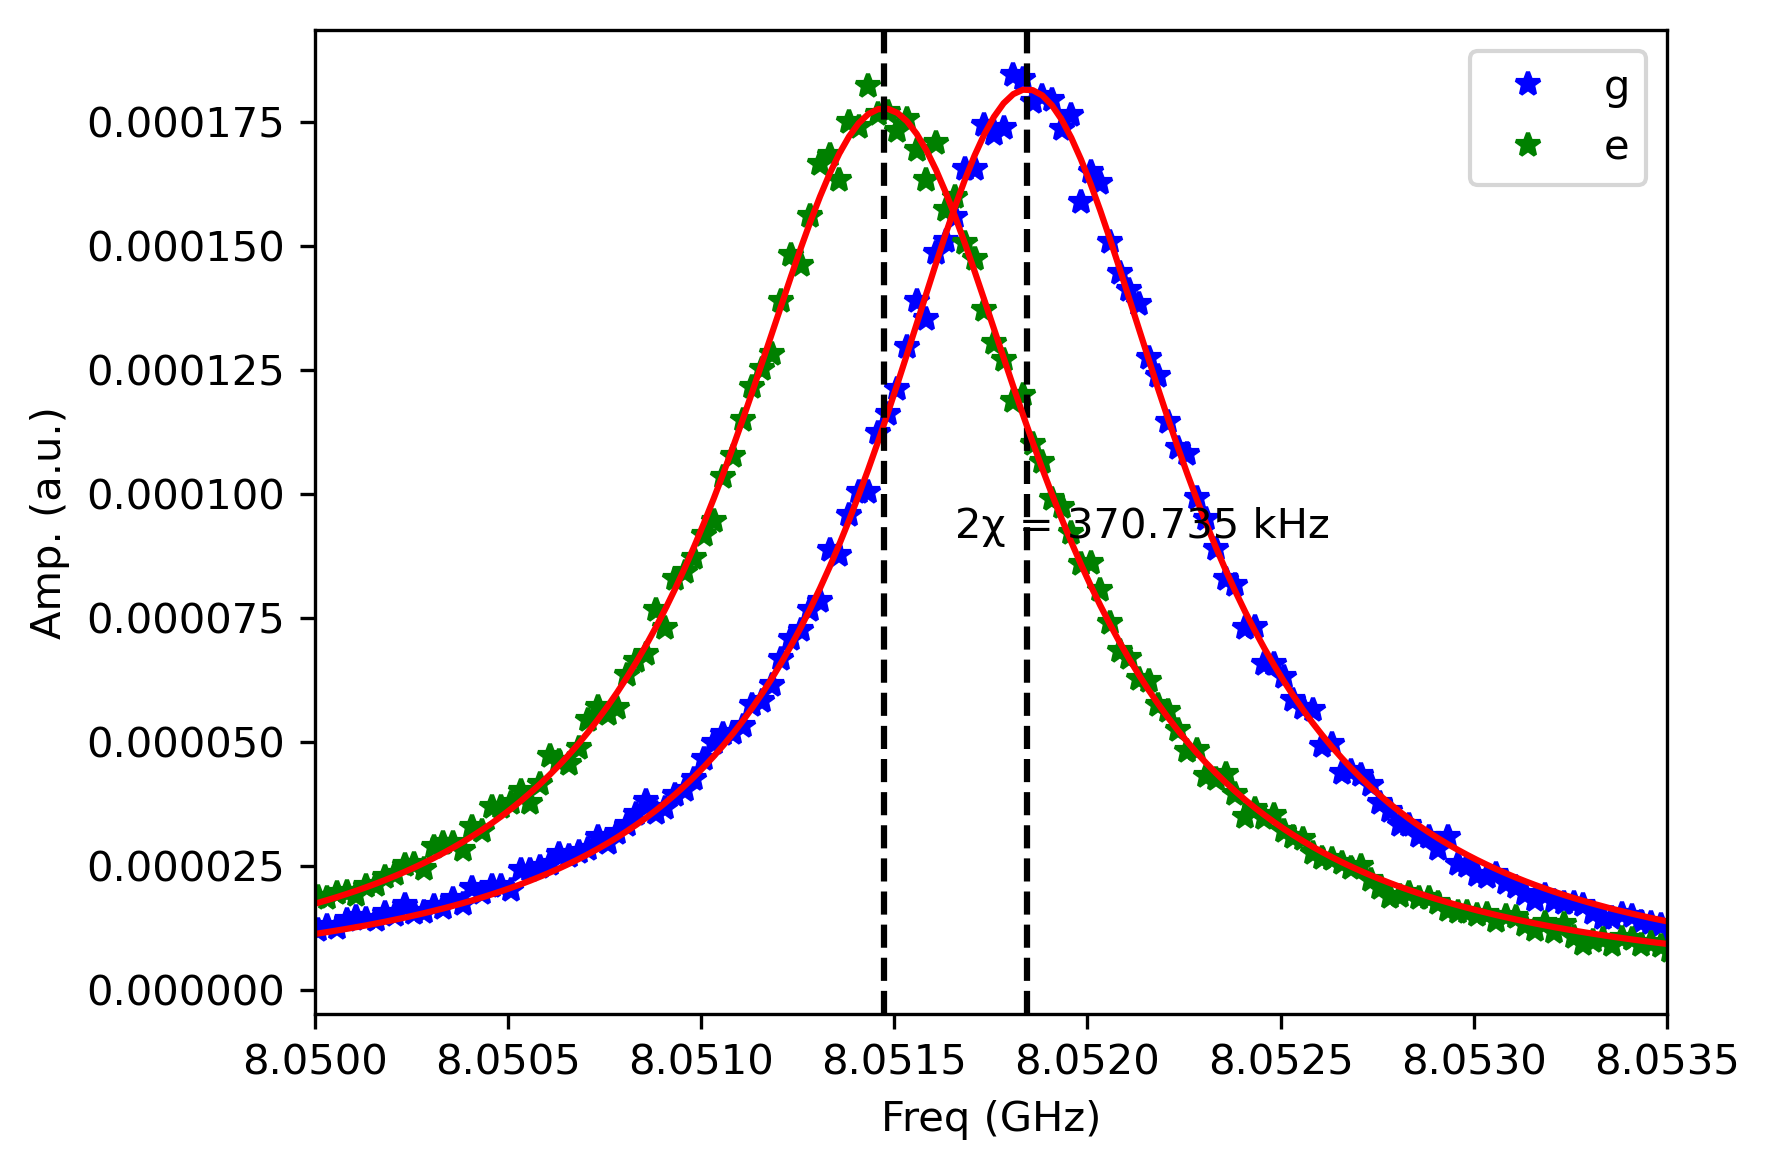

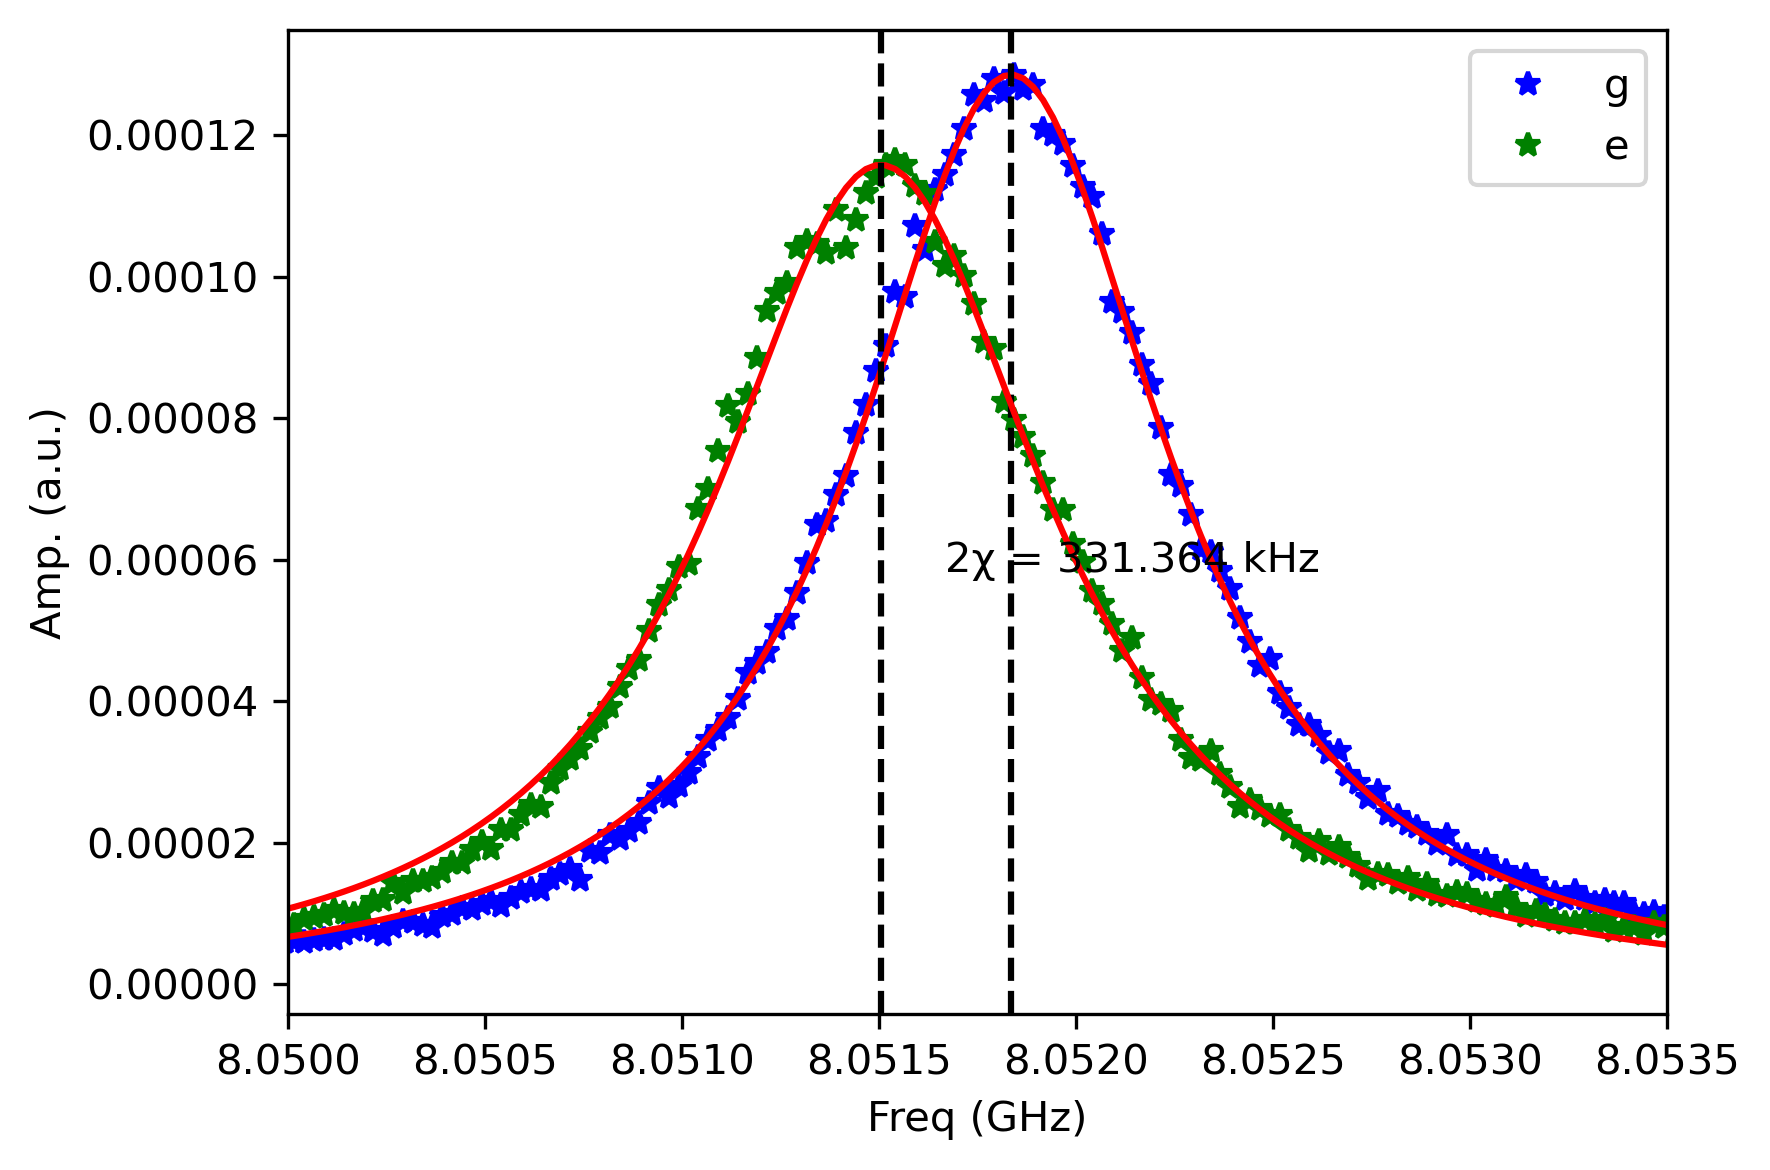

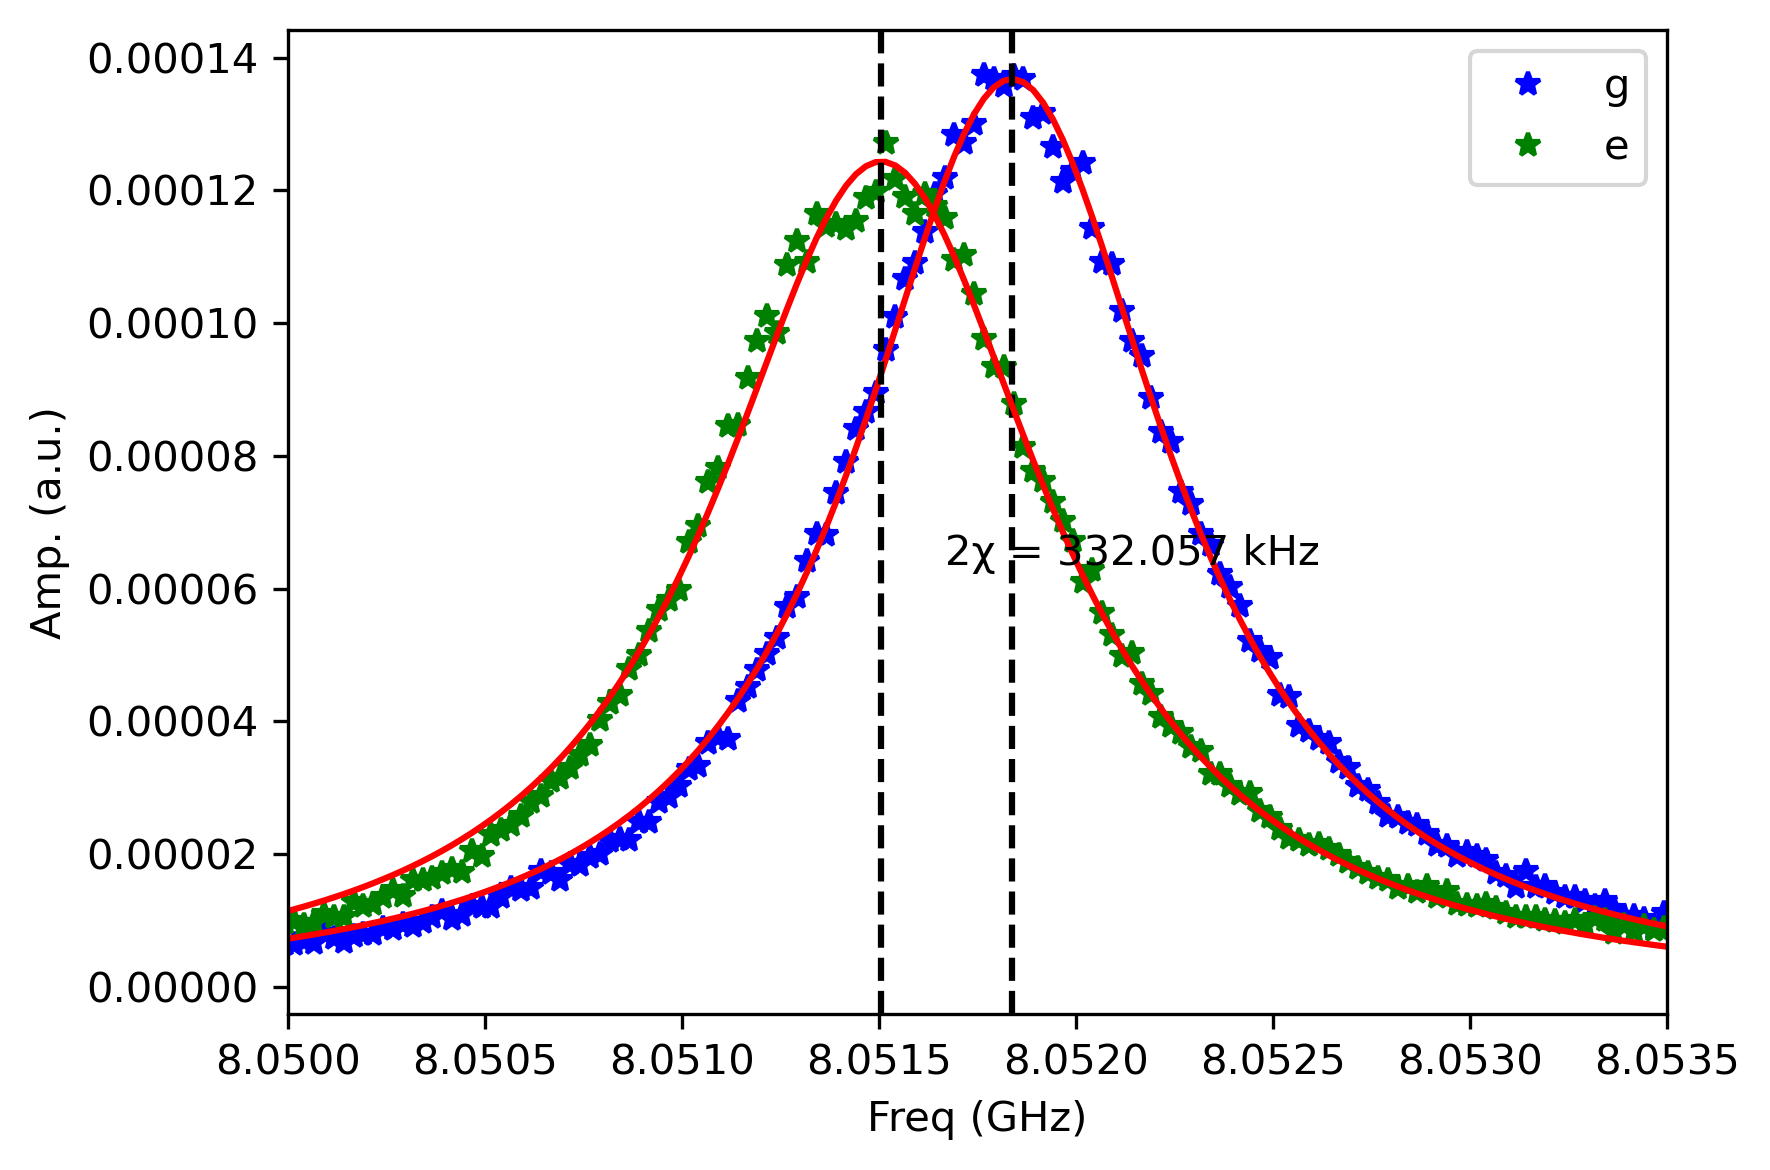

In [698]:
expt_name = 'resonator_chi'
filelist = [2,  19, 20]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='g')
    ax1.plot(f, amps_e, 'g*', label='e')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
    ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
    ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
    plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [699]:
0.5*(pg[2]+ pe[2])

8.051671474229405

In [484]:
chi_mem_qubit = 1.13e6
t_min = int((np.pi/chi_mem_qubit)*1e9/4 * 0.5)
t_max = int((np.pi/chi_mem_qubit)*1e9/4 * 1.5)
print(t_min, t_max)

347 1042


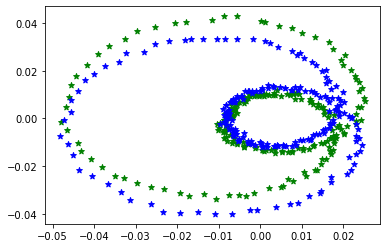

In [77]:
plt.scatter(ig, qg, color='g', marker='*')
plt.scatter(ie, qe, color='b', marker='*')

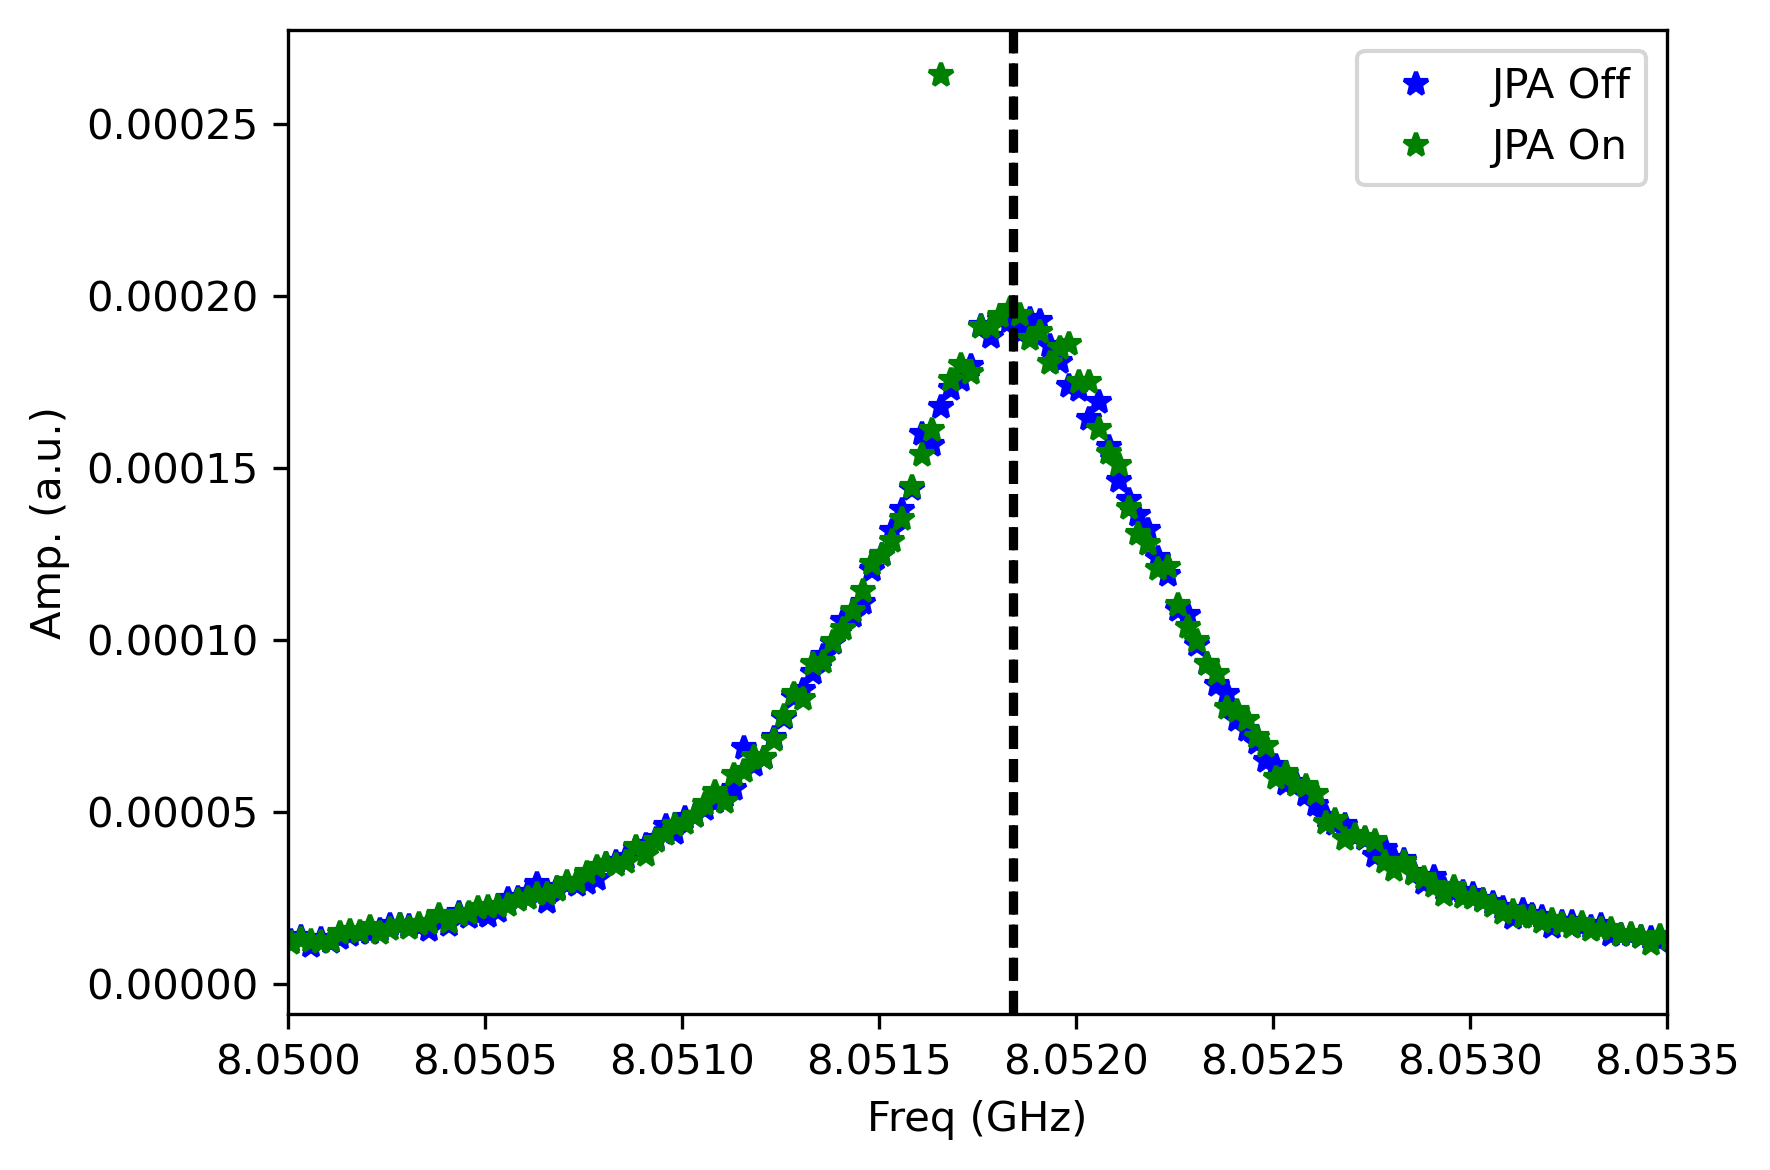

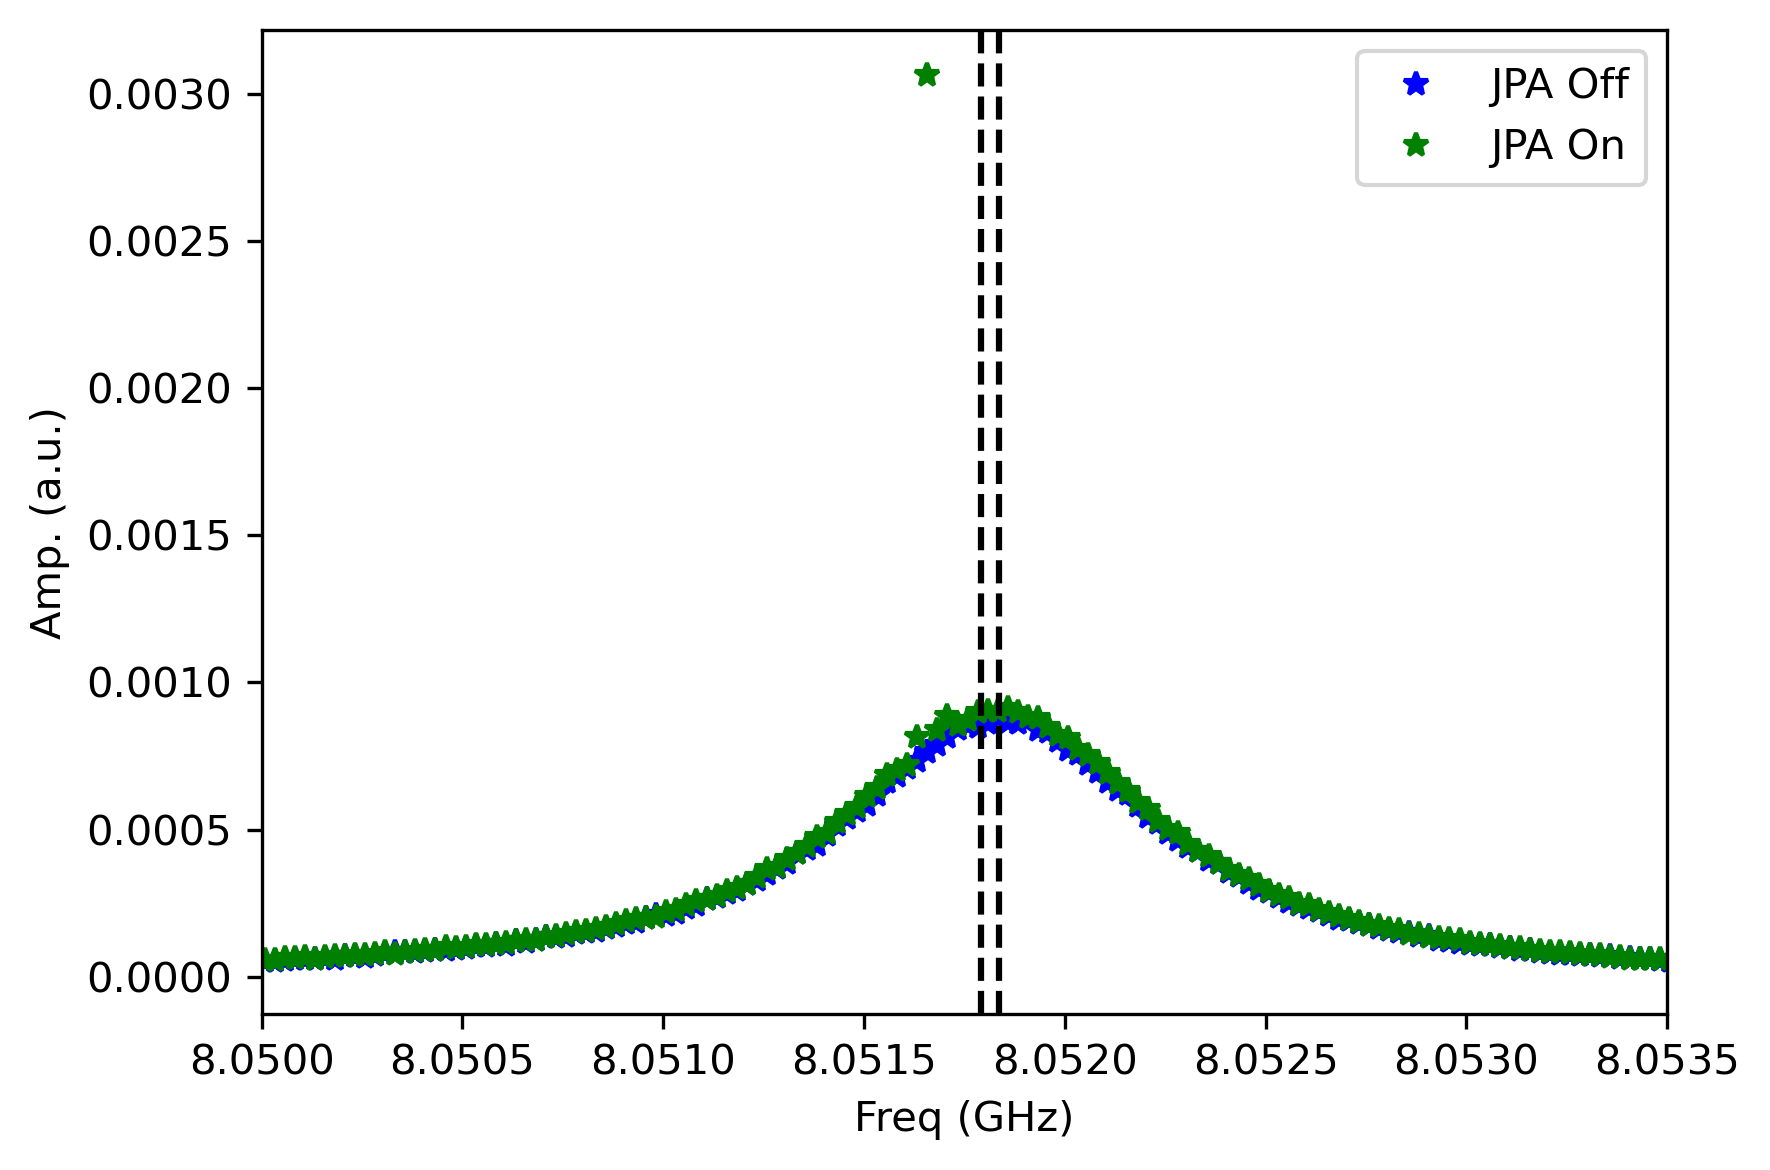

In [180]:
expt_name = 'resonator_jpa'
filelist = [0, 14]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        ig = np.array(a['Ig']) 
        qg = np.array(a['Qg']) 
        ie = np.array(a['Ie']) 
        qe = np.array(a['Qe']) 
        freq = np.array(a["freqs"]) 
        a.close()

    amps_g = (ig**2 + qg**2)
    amps_e = (ie**2 + qe**2)
    f = np.array(freq/1e9)

    fig, ax1 = plt.subplots(1, 1, dpi=300)
    ax1.plot(f, amps_g, 'b*', label='JPA Off')
    ax1.plot(f, amps_e, 'g*', label='JPA On')
    ax1.set_xlim(8.05, 8.0535)
    pg = fitlor(f, amps_g, showfit=False)
#     ax1.plot(f, lorfunc(pg, f), 'r')
    plt.axvline(x=pg[2], color='k', linestyle='--')
    pe = fitlor(f, amps_e, showfit=False)
#     ax1.plot(f, lorfunc(pe, f), 'r')
    plt.axvline(x=pe[2], color='k', linestyle='--')
    chi = (pg[2]-pe[2])*1e6
#     plt.text(np.mean(f), np.max(amps_e)*0.5, '2χ = %.3f kHz'%chi)
    plt.legend(loc='best')
    plt.xlabel('Freq (GHz)')
    plt.ylabel('Amp. (a.u.)')
#     plt.ylim(0, 25e-5)
    fig.tight_layout()
#     plt.savefig('../plots/readout_chi.png', dpi=300)
    plt.show()

In [18]:
pg[2]/(2*pg[3])

8361.458917615915

# Qubit ge spectroscopy

fits =  [-2.53528334e-02  1.81586693e-03  4.74691305e+00  8.98604266e-04]
fits =  [-4.39899912e-03  4.21271361e-04  4.74688355e+00  8.79488321e-04]
fits =  [-5.48014590e-03  5.62819435e-05  4.74515104e+00  2.45774076e-03]
fits =  [-7.19151398e-04  3.83886014e-05  4.74694182e+00  6.21859591e-04]
fits =  [-1.44916649e-02  6.28498006e-04  4.74698147e+00  6.23383140e-04]


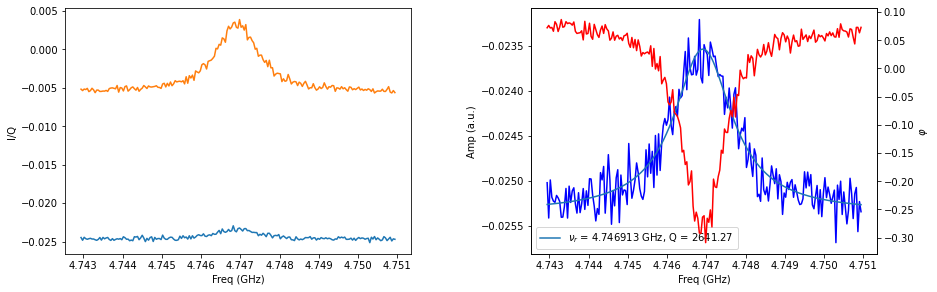

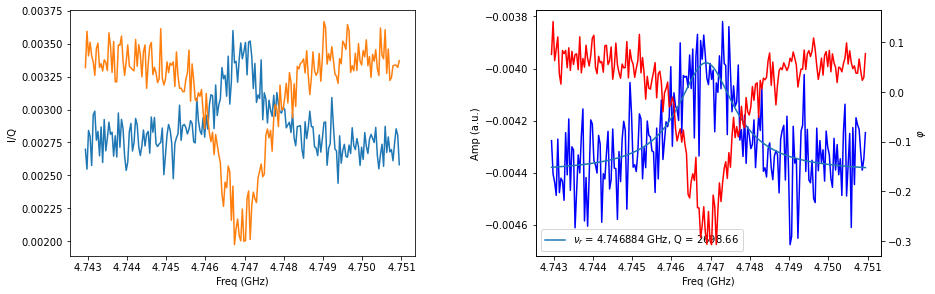

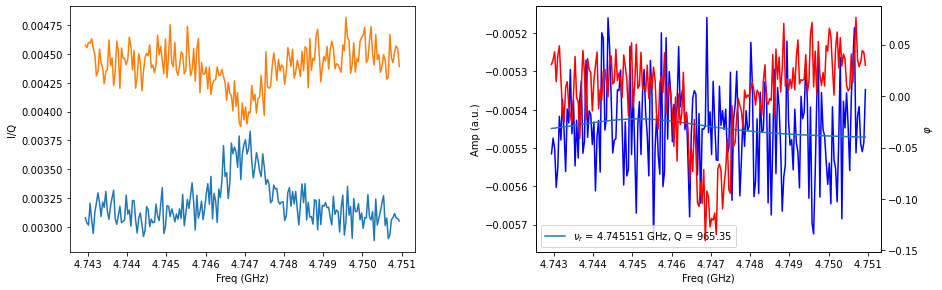

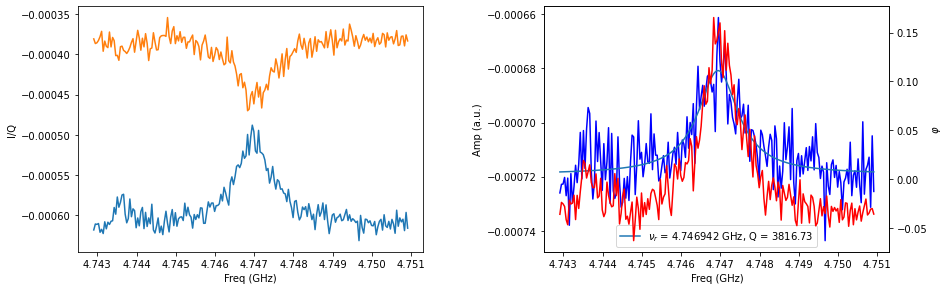

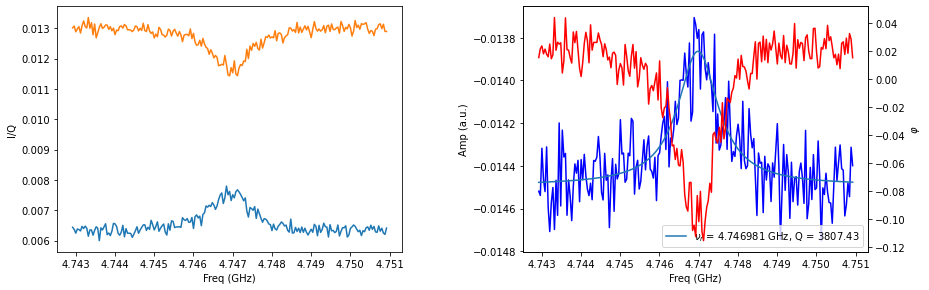

In [731]:
expt_name = 'ge_spectroscopy'
filelist = [0, 16, 19, 22, 27]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['freqs'])/1e9
        a.close()
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    axs[0].plot(x, I)
    axs[0].plot(x, Q)
    axs[0].set_xlabel('Freq (GHz)')
    axs[0].set_ylabel('I/Q')
    amps = -np.sqrt(np.array(I)**2 + 1*np.array(Q)**2)
#     amps = Q
    ph = np.arctan2(np.array(Q), np.array(I))
    ph = np.unwrap(ph, discont=3.141592653589793, axis=-1)
    m = (ph[-1]-ph[0])/(x[-1] - x[0])
    ph = ph - m*x*0.95
    ph = ph -np.mean(ph)
    axs[1].plot(x, amps, 'b-')
    p = fitlor(x, amps, showfit=False)
    q = p[2]/(2*p[3])
    axs[1].plot(x, lorfunc(p, x), label=r'$\nu_{r}$ = %.6f GHz, Q = %.2f'% (p[2], q))
    print ("fits = ", p)
    ax2  = axs[1].twinx()
    ax2.plot(x, ph, 'r-')
    axs[1].set_xlabel('Freq (GHz)')
    axs[1].set_ylabel('Amp (a.u.)')
    ax2.set_ylabel('$\\varphi$')
    axs[1].legend(loc='best')

# Ramsey

Original qubit frequency choice = 4.746942812186551 GHz
Oscillation freq =  0.0989423086014202  MHz
Offset freq = 0.0010576913985798075 MHz
Suggested qubit frequency choice = 4.746943869877949 GHz
T2* = 117.02825247568352 us
Original qubit frequency choice = 4.746943660718653 GHz
Oscillation freq =  0.09905879291075721  MHz
Offset freq = 0.0009412070892427932 MHz
Suggested qubit frequency choice = 4.746944601925742 GHz
T2* = 128.53845261335428 us
Original qubit frequency choice = 4.7472 GHz
Oscillation freq =  0.3768167146084203  MHz
Offset freq = -0.2768167146084203 MHz
Suggested qubit frequency choice = 4.746923183285392 GHz
T2* = 106.55373949835219 us


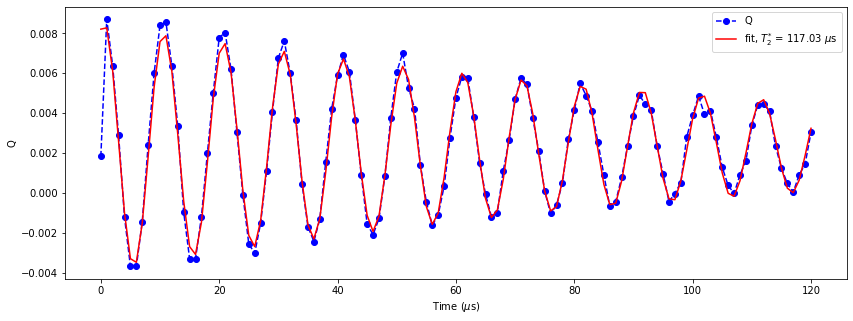

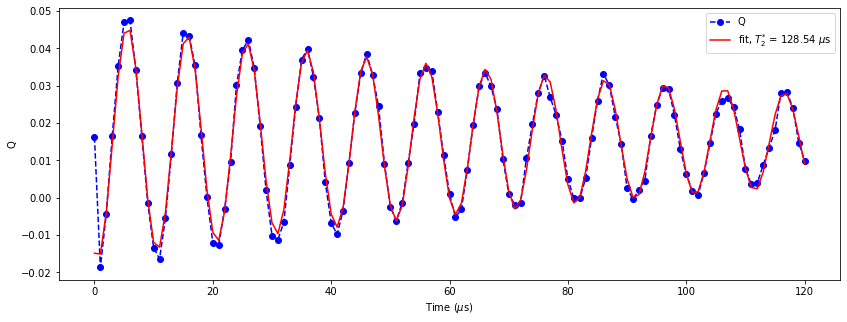

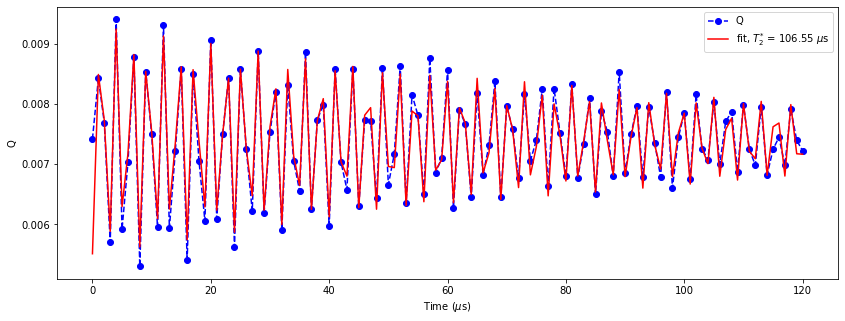

In [589]:
expt_name = 'Ramsey'
filelist = [0, 22, 58]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

## Ramsey JPA

Original qubit frequency choice = 4.7469435020521695 GHz
Oscillation freq =  0.09905722547473618  MHz
Offset freq = 0.0009427745252638259 MHz
Suggested qubit frequency choice = 4.746944444826695 GHz
T2* = 131.90379799340798 us
Original qubit frequency choice = 4.746923768963945 GHz
Oscillation freq =  0.09926695756660499  MHz
Offset freq = 0.0007330424333950175 MHz
Suggested qubit frequency choice = 4.746924502006378 GHz
T2* = 110.48990461332085 us


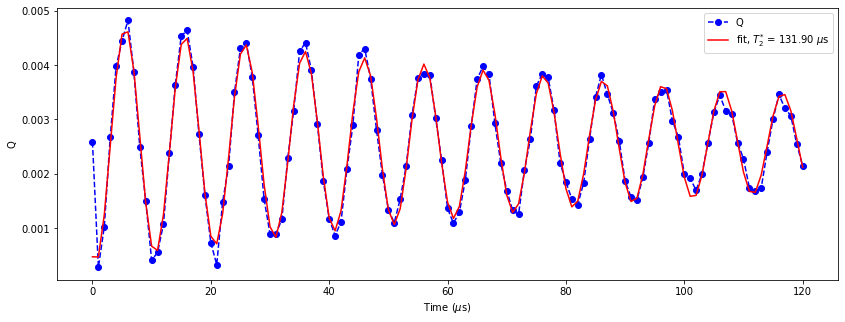

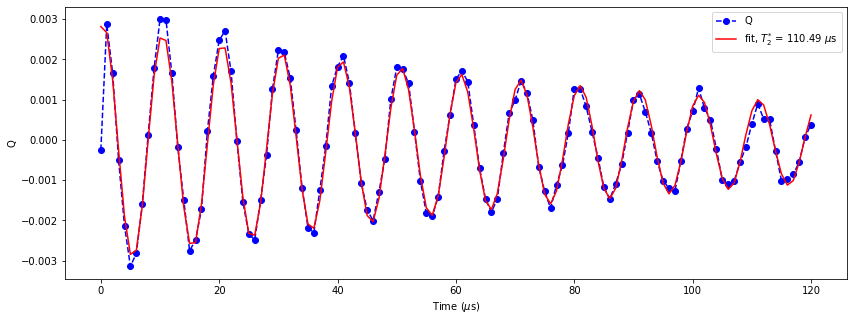

In [630]:
expt_name = 'Ramsey_jpa'
filelist = [0, 1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

# Ramsey Phase

Original qubit frequency choice = 4.746910599438208 GHz
Oscillation freq =  0.0999671987344142  MHz
Offset freq = 3.280126558580232e-05 MHz
Suggested qubit frequency choice = 4.746910632239474 GHz
T2* = 128.90311883078616 us
Original qubit frequency choice = 4.746926375792361 GHz
Oscillation freq =  0.10122630687897882  MHz
Offset freq = -0.0012263068789788167 MHz
Suggested qubit frequency choice = 4.746925149485482 GHz
T2* = 109.65690701878695 us


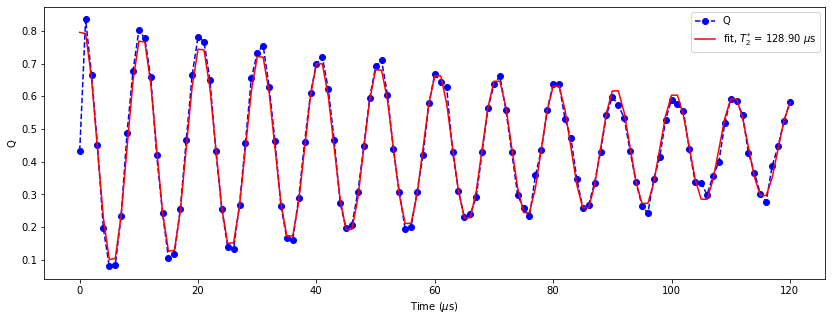

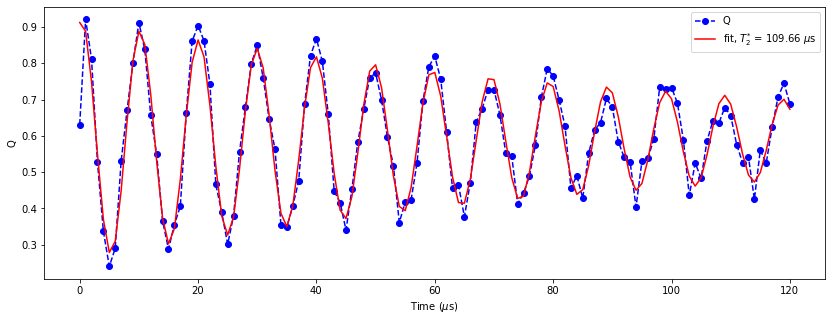

In [737]:
expt_name = 'Ramsey_phase'
filelist = [28, 75]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = Q
        
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

## ef Ramsey

Original qubit frequency choice = 4.6078190022032635 GHz
Oscillation freq =  67280.99340576485  MHz
Offset freq = -67280.89340576484 MHz
Suggested qubit frequency choice = -62.67307440356158 GHz
T2* = 5.7517302234613365e-05 us


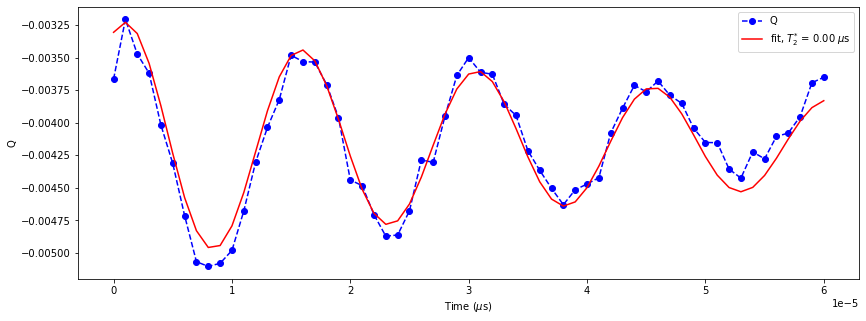

In [149]:
expt_name = 'ef_Ramsey_phase'
filelist = [1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        t = array(a['time'])
        ramsey_freq = array(a['ramsey_freq'])/1e6
        qubit_freq = array(a['qubit_freq'])/1e9
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        P = I
        
        p = fitdecaysin(t[:], P[:],fitparams = None, showfit=False)
        ax.plot(t, P, 'bo--',label = 'Q')
        ax.plot(t[:], decaysin(np.append(p, 0), t[:]), 'r-', label=r'fit, $T_{2}^{*}$ = %.2f $\mu$s' % p[3])
        offset = ramsey_freq - p[1]
        nu_q_new = qubit_freq + offset/1e3
        print("Original qubit frequency choice =", qubit_freq,"GHz")
        print ("Oscillation freq = ", p[1]," MHz")
        print("Offset freq =", offset,"MHz")
        print("Suggested qubit frequency choice =", nu_q_new,"GHz")
        print("T2* =", p[3],"us")
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()

# Power Rabi

Suggested π amp = 0.3505
0.811 0.141
Suggested π amp = 0.3645
0.9365 0.2065


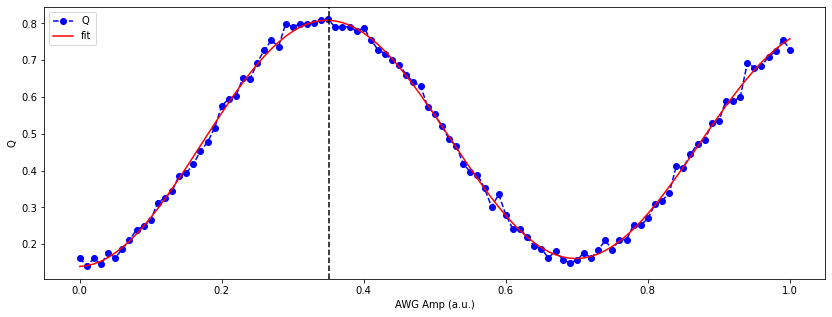

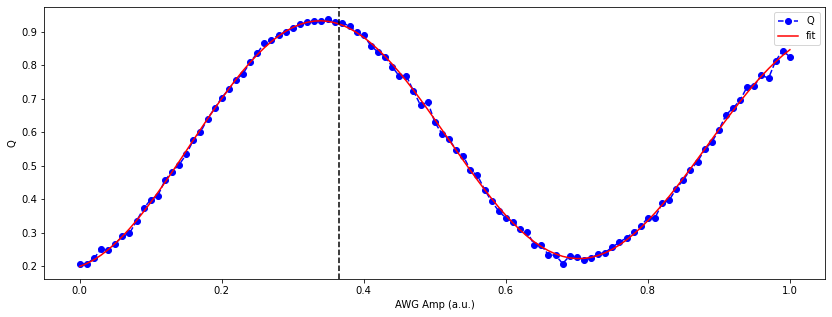

In [736]:
expt_name = 'power_rabi'
filelist = [111, 145]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = %.4f" %(1/2/p[1]))
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()
        
        print(max(Q), min(Q))

## ef Power Rabi

Suggested π amp = 0.4167
Suggested π amp = 0.4222


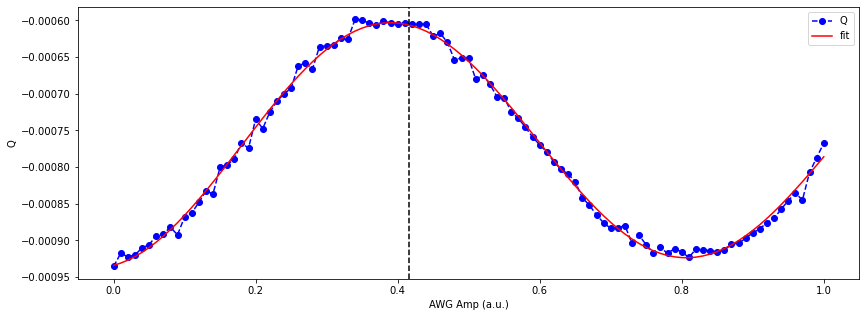

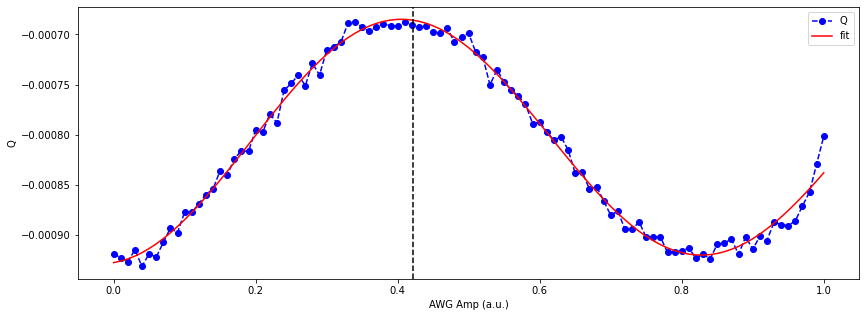

In [283]:
expt_name = 'ef_power_rabi'
filelist = [0, 8]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = %.4f" %(1/2/p[1]))
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()

# ge Weak Rabi

Suggested π amp = 0.0037
0.7353 0.0235
Suggested π amp = 0.0036
0.7154 0.025
Suggested π amp = 0.0036
0.8886 0.1138
Suggested π amp = 0.0038
0.8905 0.1341


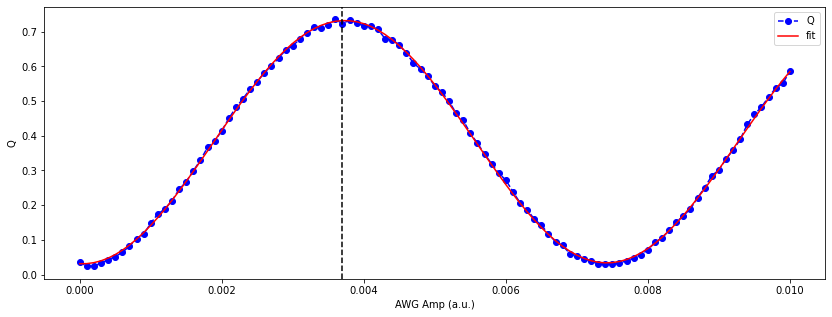

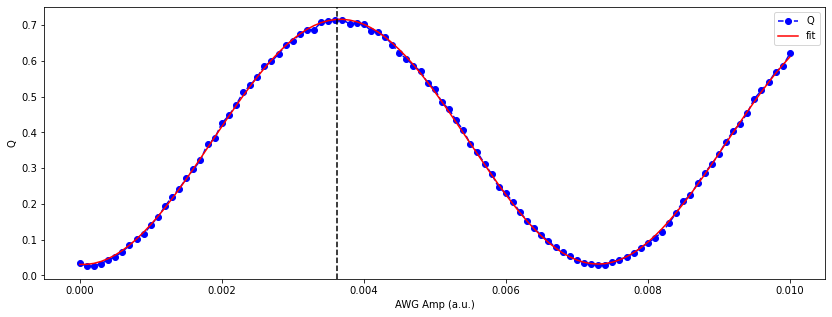

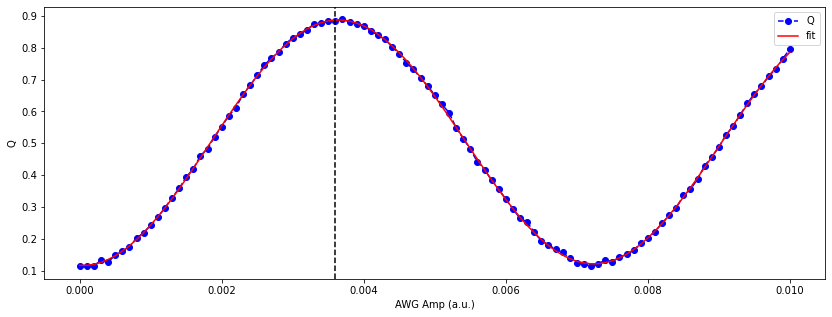

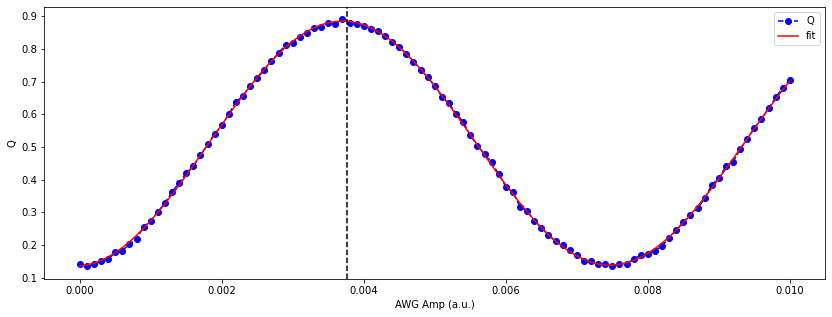

In [598]:
expt_name = 'weak_rabi'
filelist = [1, 2, 7, 9]
freq = []
t2 = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['amps'])
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitdecaysin(x[:], y[:],fitparams = None, showfit=False)
        ax.plot(x, y, 'bo--',label = 'Q')
        ax.plot(x[:], decaysin(np.append(p, 0), x[:]), 'r-', label=r'fit')
        print("Suggested π amp = %.4f" %(1/2/p[1]))
        ax.axvline(1/2/p[1], color='k', linestyle='--')
        ax.set_xlabel('AWG Amp (a.u.)')
        ax.set_ylabel('Q')
        ax.legend()
        print(max(Q), min(Q))

# T1

T1: 99.926 μs
0.831 0.046
T1: 106.080 μs
0.811 0.059
T1: 95.270 μs
0.589 0.057


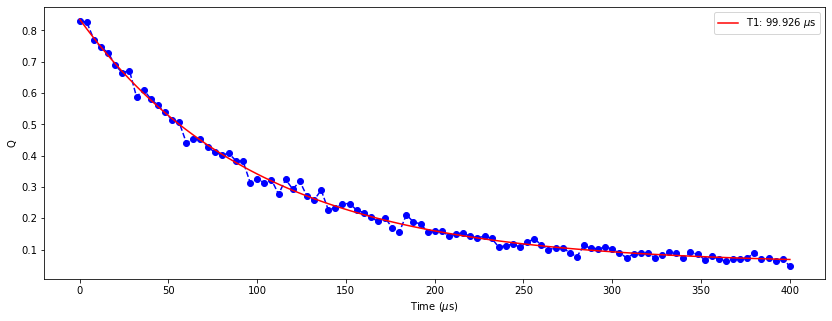

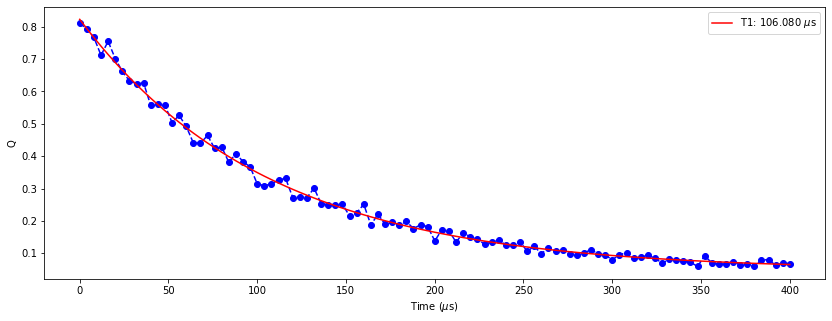

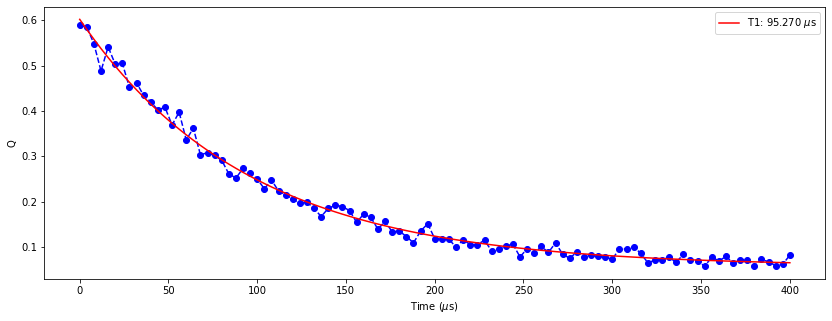

In [692]:
expt_name = 't1'
filelist = [34, 35, 39]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        p = fitexp(x, y, showfit=False)
        print("T1: %.3f μs"%(p[3]))
        ax.plot(x, y, 'bo--')
        ax.plot(x[:], expfunc(p, x[:]), 'r-', label='T1: %.3f $\mu$s'%(p[3]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()
        print(max(Q), min(Q))

(0.806, 0.058)

## ef T1

T1: 39.512 μs


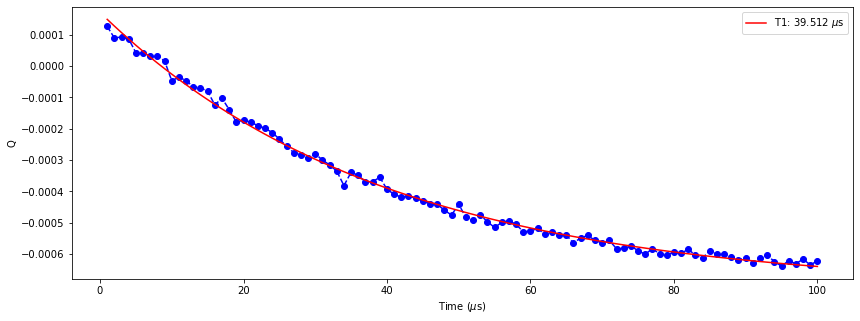

In [285]:
expt_name = 'ef_t1'
filelist = [1]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['Q'])
        x = array(a['times'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = I
        p = fitexp(x, y, showfit=False)
        print("T1: %.3f μs"%(p[3]))
        ax.plot(x, y, 'bo--')
        ax.plot(x[:], expfunc(p, x[:]), 'r-', label='T1: %.3f $\mu$s'%(p[3]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()


## Storage T1

[9.01682404e-02 8.16793610e+02 3.96013533e-02]
T1: 816.794 μs
0.123 0.027


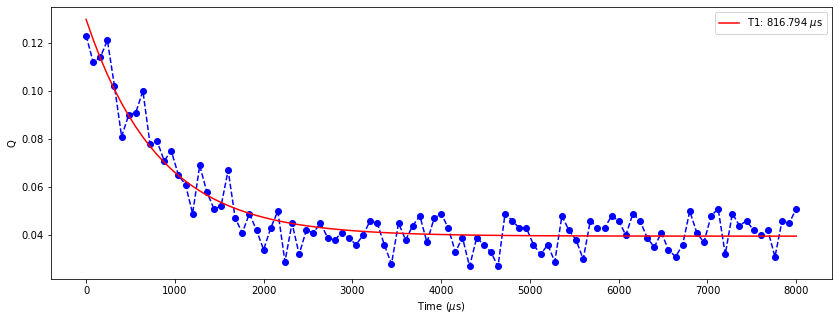

In [724]:
expt_name = 'storage_t1'
filelist = [3]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        
        fig, ax = plt.subplots(1, 1, figsize=(14,5))

        y = Q
        popt, pcov = curve_fit(expfunc_baseline, x, y)
        print(popt)
        print("T1: %.3f μs"%(popt[1]))
        ax.plot(x, y, 'bo--')
        ax.plot(x, expfunc_baseline(x, *popt), 'r-', label='T1: %.3f $\mu$s'%(popt[1]))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('Q')
        ax.legend()
        print(max(Q), min(Q))

# Qubit temperature

[-1.28712096e-04  4.96591477e+00  1.05082529e+02  6.91840042e+00
  6.73067088e-05]
[-7.91366114e-06  5.15897473e+00  9.55997725e+01  1.64820806e+05
 -5.06497493e-04]
ge contrast ratio =  0.061483429899657056
Qubit Temp: 74.00083637574171  mK
Qubit Excited State Occupation: 0.05792217586050227
[-8.04742653e-05  4.95623347e+00  1.02855953e+02  9.92432010e+00
 -1.22545331e-04]
[-3.11094939e-06  1.32059488e+01  4.25638769e+01  1.26818197e+05
 -5.98271019e-04]
ge contrast ratio =  0.03865769238536874
Qubit Temp: 63.445069323075685  mK
Qubit Excited State Occupation: 0.037218895762075335


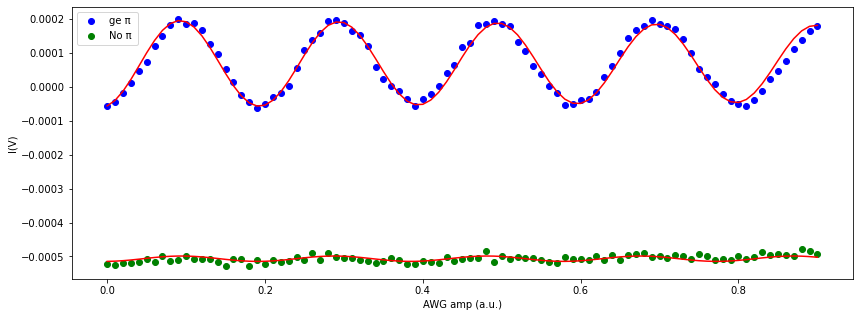

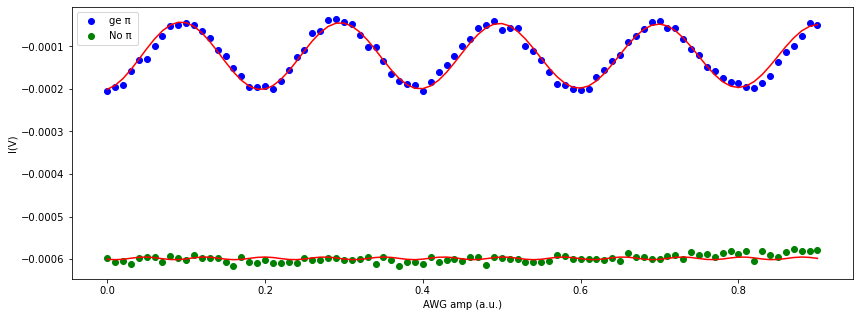

In [312]:
expt_name = 'qubit_temp'
filelist = [6, 9]

def temperature_q(nu, rat):
    Kb = 1.38e-23
    h = 6e-34
    return h*nu/(Kb*log(1/rat))

def occupation_q(nu,T):
    Kb = 1.38e-23
    h = 6e-34
    T = T*1e-3
    return 1/(exp(h*nu/(Kb*T))+1)

q_pop = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        Ie = array(a['Ie'])[:-10]
        Qe = array(a['Qe'])[:-10]
        Ig = array(a['Ig'])[:-10]
        Qg = array(a['Qg'])[:-10]

        x = array(a['amps'])[:-10]
        
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
        axs.plot(x, Ig,'bo',label = 'ge π ')
        axs.plot(x, Ie,'go',label = 'No π ')        
        axs.set_xlabel('AWG amp (a.u.)')
        axs.set_ylabel('I(V)')
        axs.legend()
        pg = fitdecaysin(x, Ig, showfit=False)
        print(pg)
        axs.plot(x, decaysin(np.append(pg, 0), x), 'r')
        pe = fitdecaysin(x, Ie, showfit=False)
        print(pe)
        axs.plot(x, decaysin(np.append(pe, 0), x), 'r')
        
        contrast_g = pg[0]
        contrast_e = pe[0]
#         ax.set_ylim(0.8, 0.95)
    nu_q = 4.7469105
    ratio = abs(contrast_e/contrast_g)
    print ("ge contrast ratio = ", ratio)
    print ("Qubit Temp:" , 1e3*temperature_q(nu_q*1e9,ratio)," mK" )
    print ("Qubit Excited State Occupation:" , occupation_q(nu_q, 1e3*temperature_q(nu_q,ratio)))
    q_pop.append(occupation_q(nu_q, 1e3*temperature_q(nu_q, ratio)))

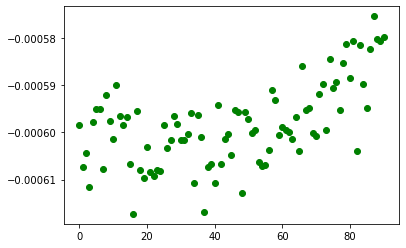

In [310]:
plt.plot(Ie, 'go')

# Histogram 

## Square

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:183: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.710
Optimal fidelity after rotation = 0.682
Optimal fidelity after rotation = 0.904


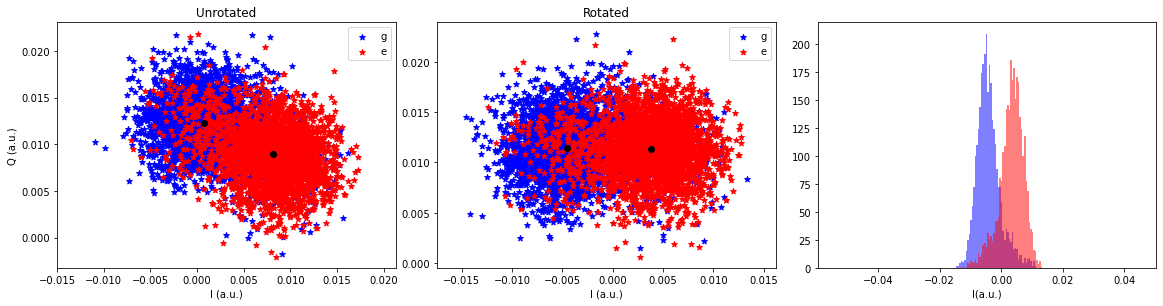

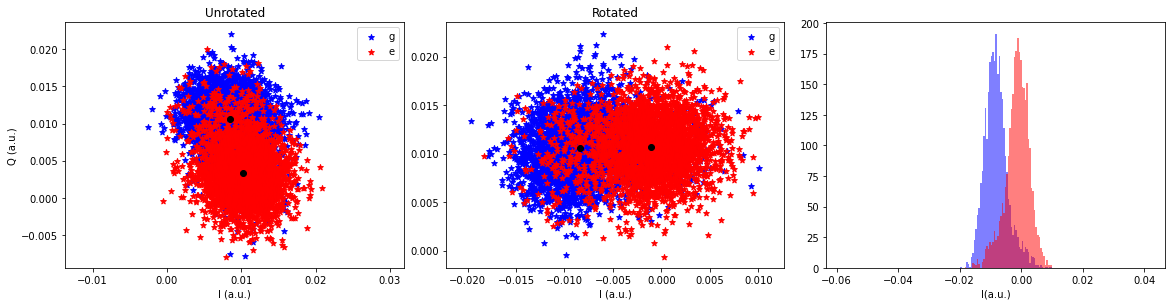

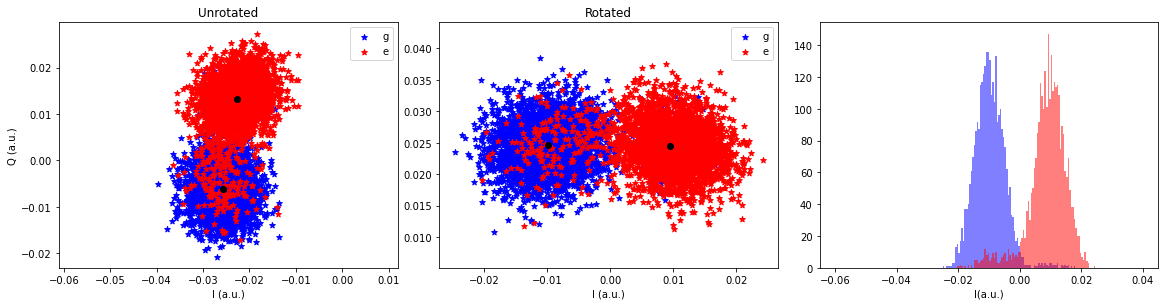

In [695]:
expt_name = 'histogram'
filelist = [35,  160, 163]

for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    fid, angle = hist(filename, data=None,  plot=True, ran=0.05)
    print('Optimal fidelity after rotation = %.3f'%fid)

### Freq and amp sweep

(1023000,)
330 0.8226666666666667


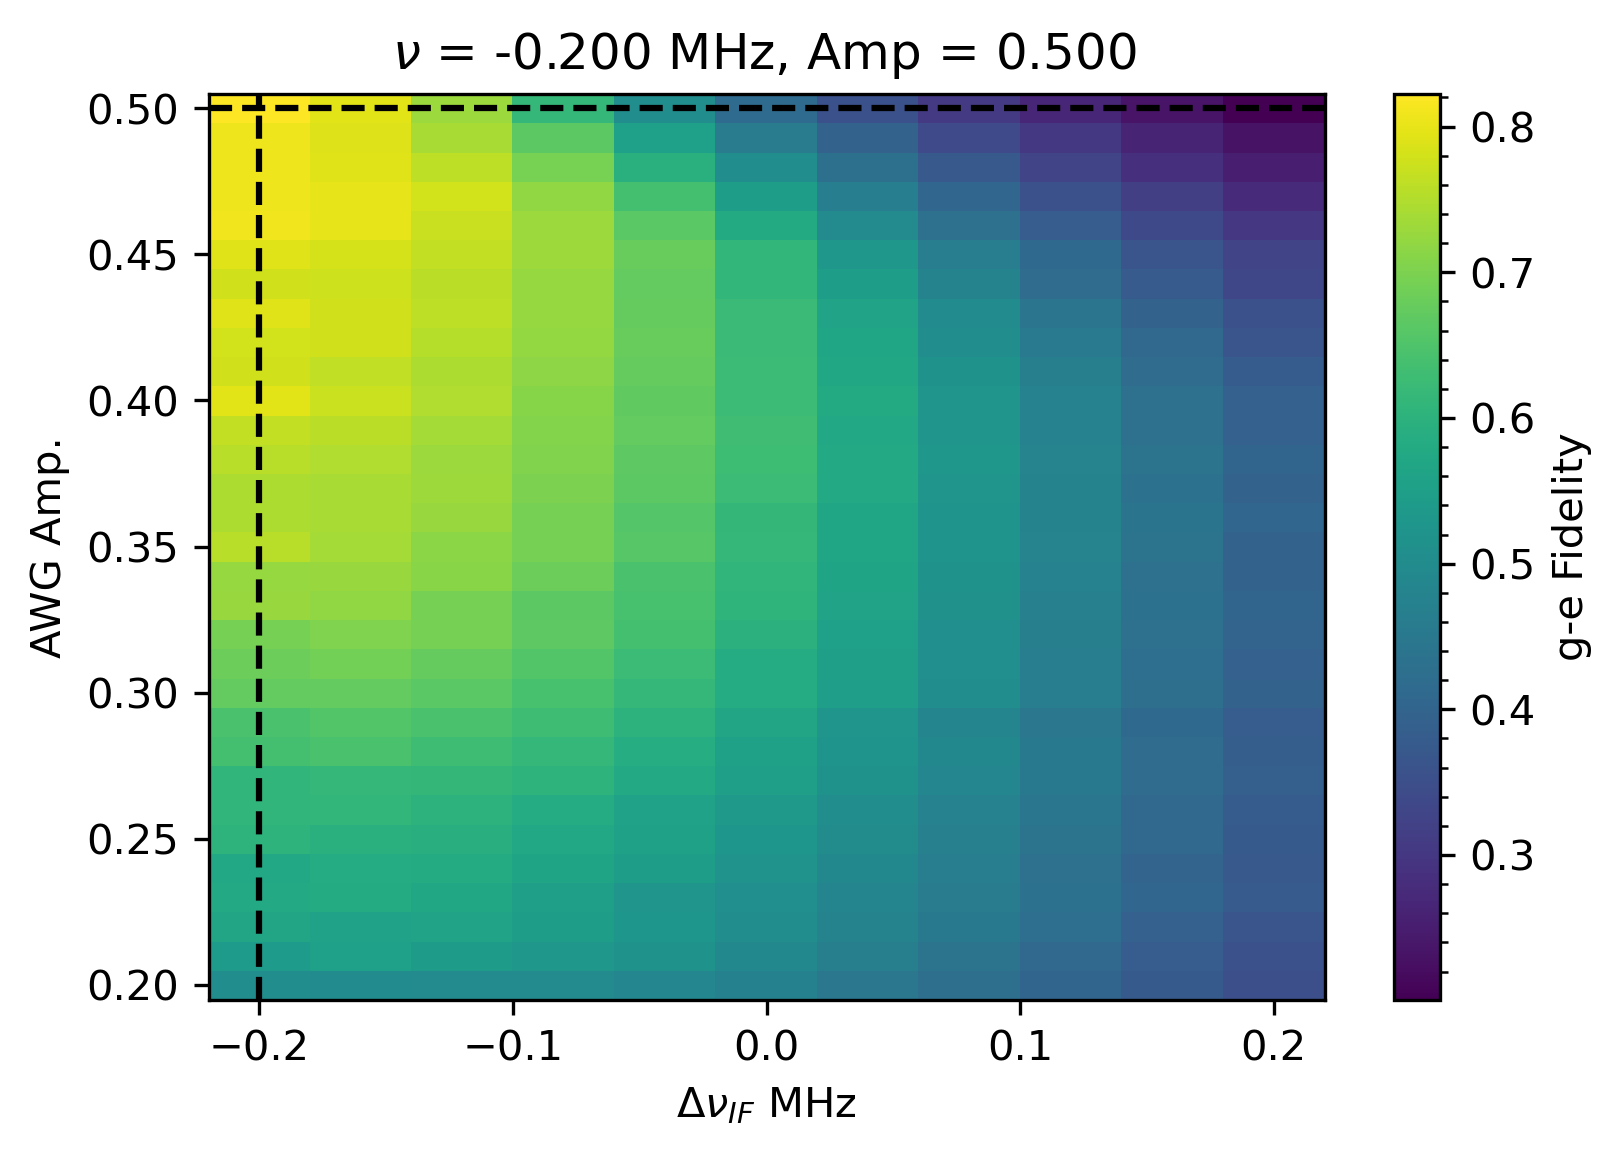

In [494]:
expt_name = 'histogram_freq_amp_sweep'
filelist = [11]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'$\nu$ = %.3f MHz, Amp = %.3f '%(freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]))
    plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
    plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
    plt.show()

In [159]:
freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]

(-0.1, 0.32)

### Amp sweep 

(93000,)


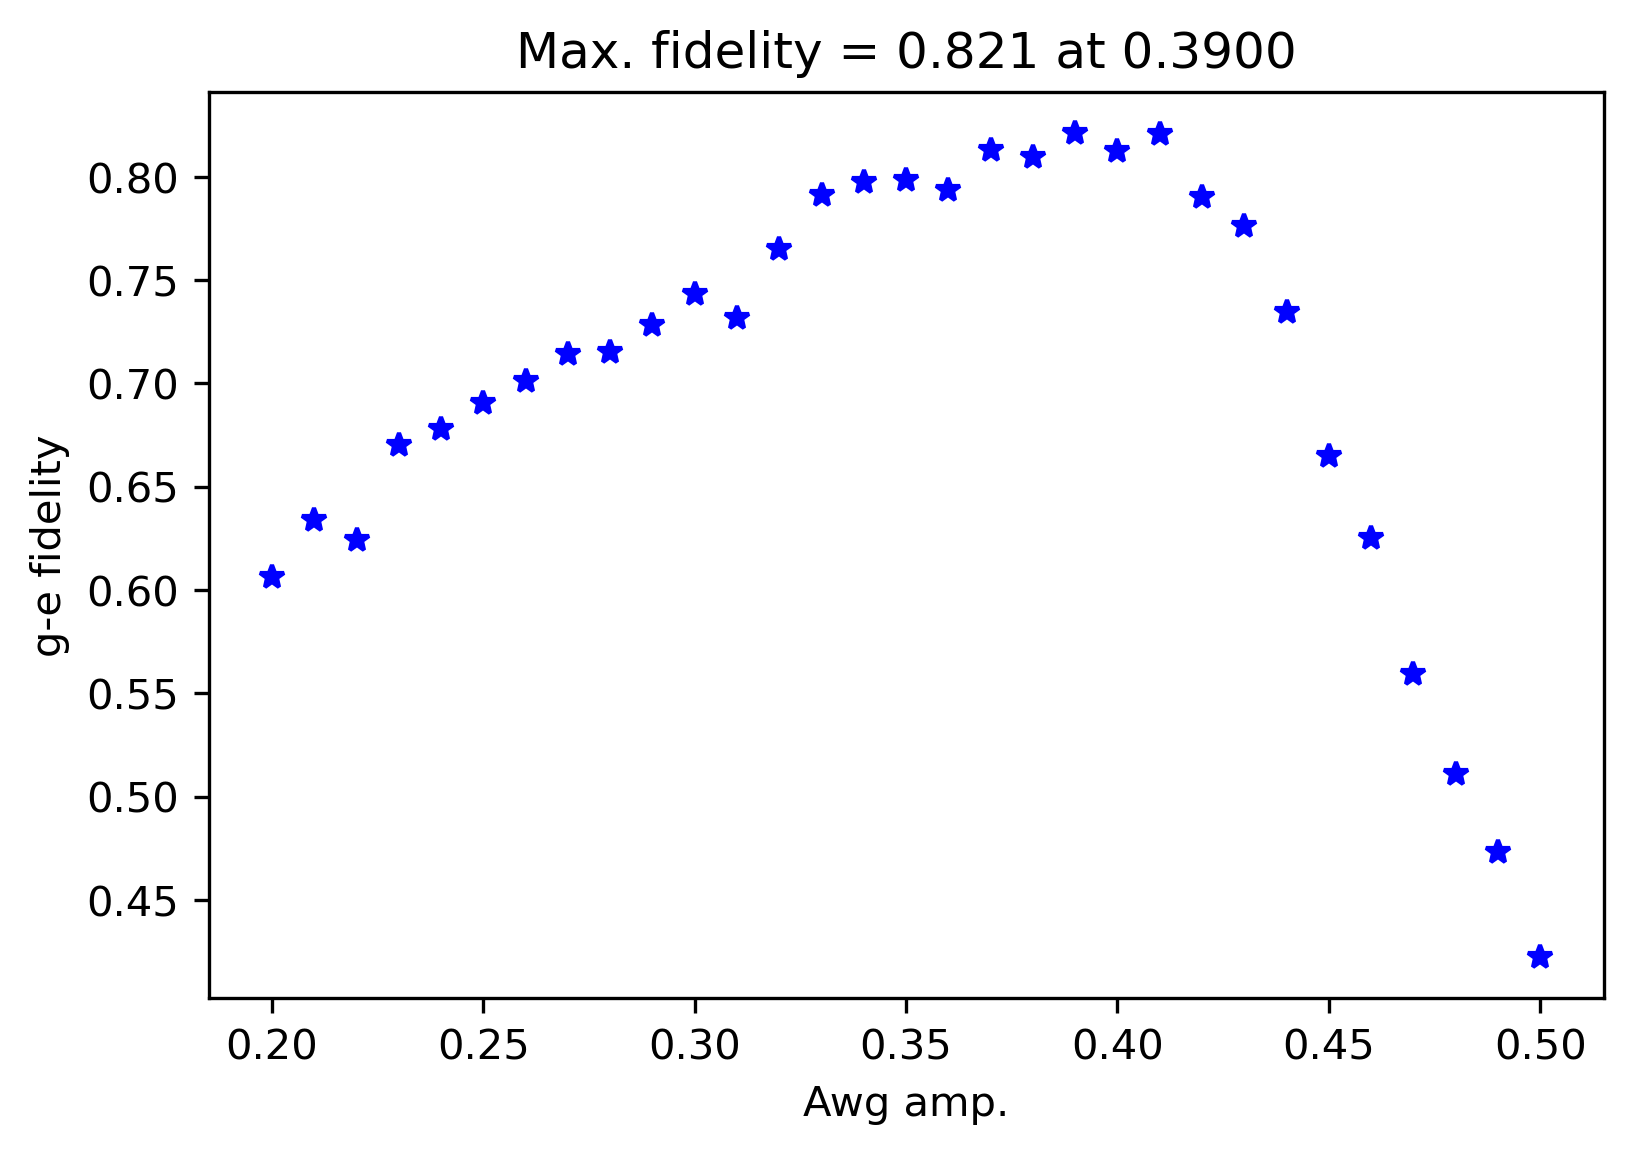

In [204]:
expt_name = 'histogram_amp_sweep'
filelist = [17]
#7 - 3us long pulse
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.02)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()

### Freq sweep

(63000,)


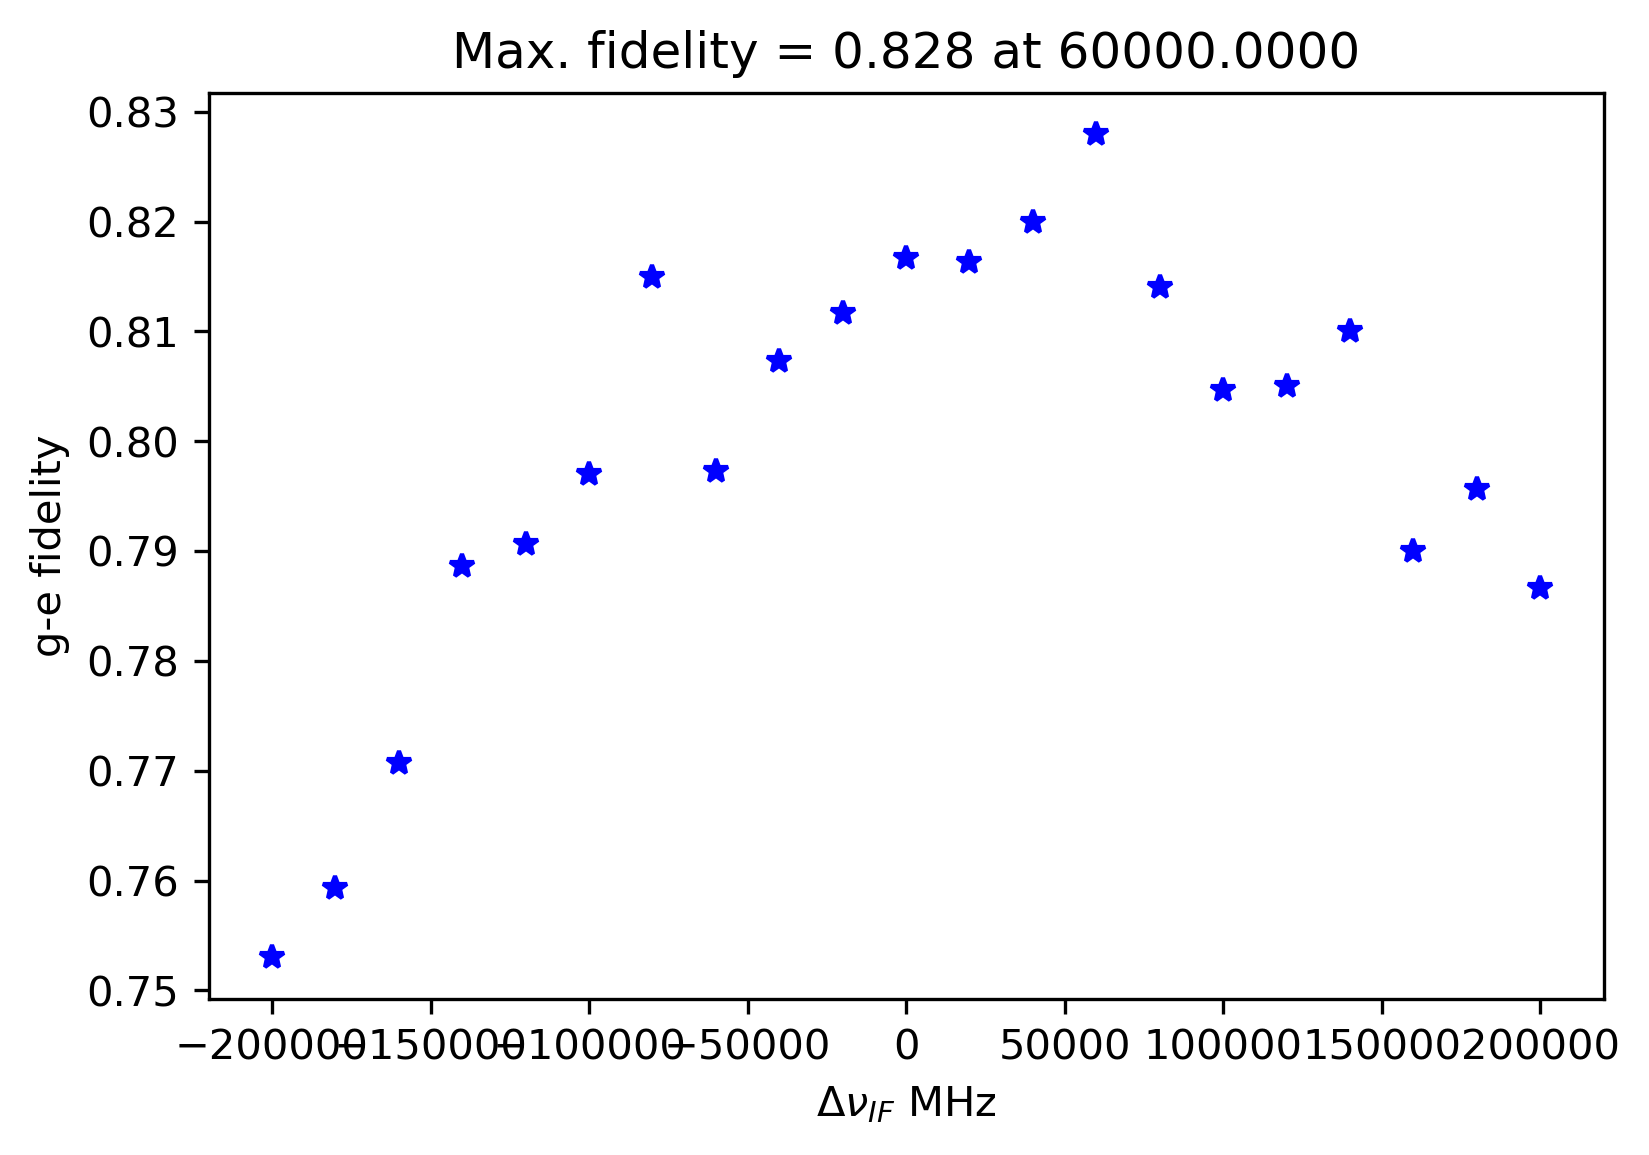

0.828


In [25]:
expt_name = 'histogram_freq_sweep'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        freq = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(freq)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.05)
        fid_f_p.append(fid)

plt.figure(dpi=300)
plt.plot(freq, fid_f_p, 'b*')
plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), freq[np.argmax(fid_f_p)]))
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('g-e fidelity')
plt.show()
print(max(fid_f_p))

(-0.1, 0.29200000000000004)

### rr and jpa amp sweep

(1323000,)
231 0.8163333333333334


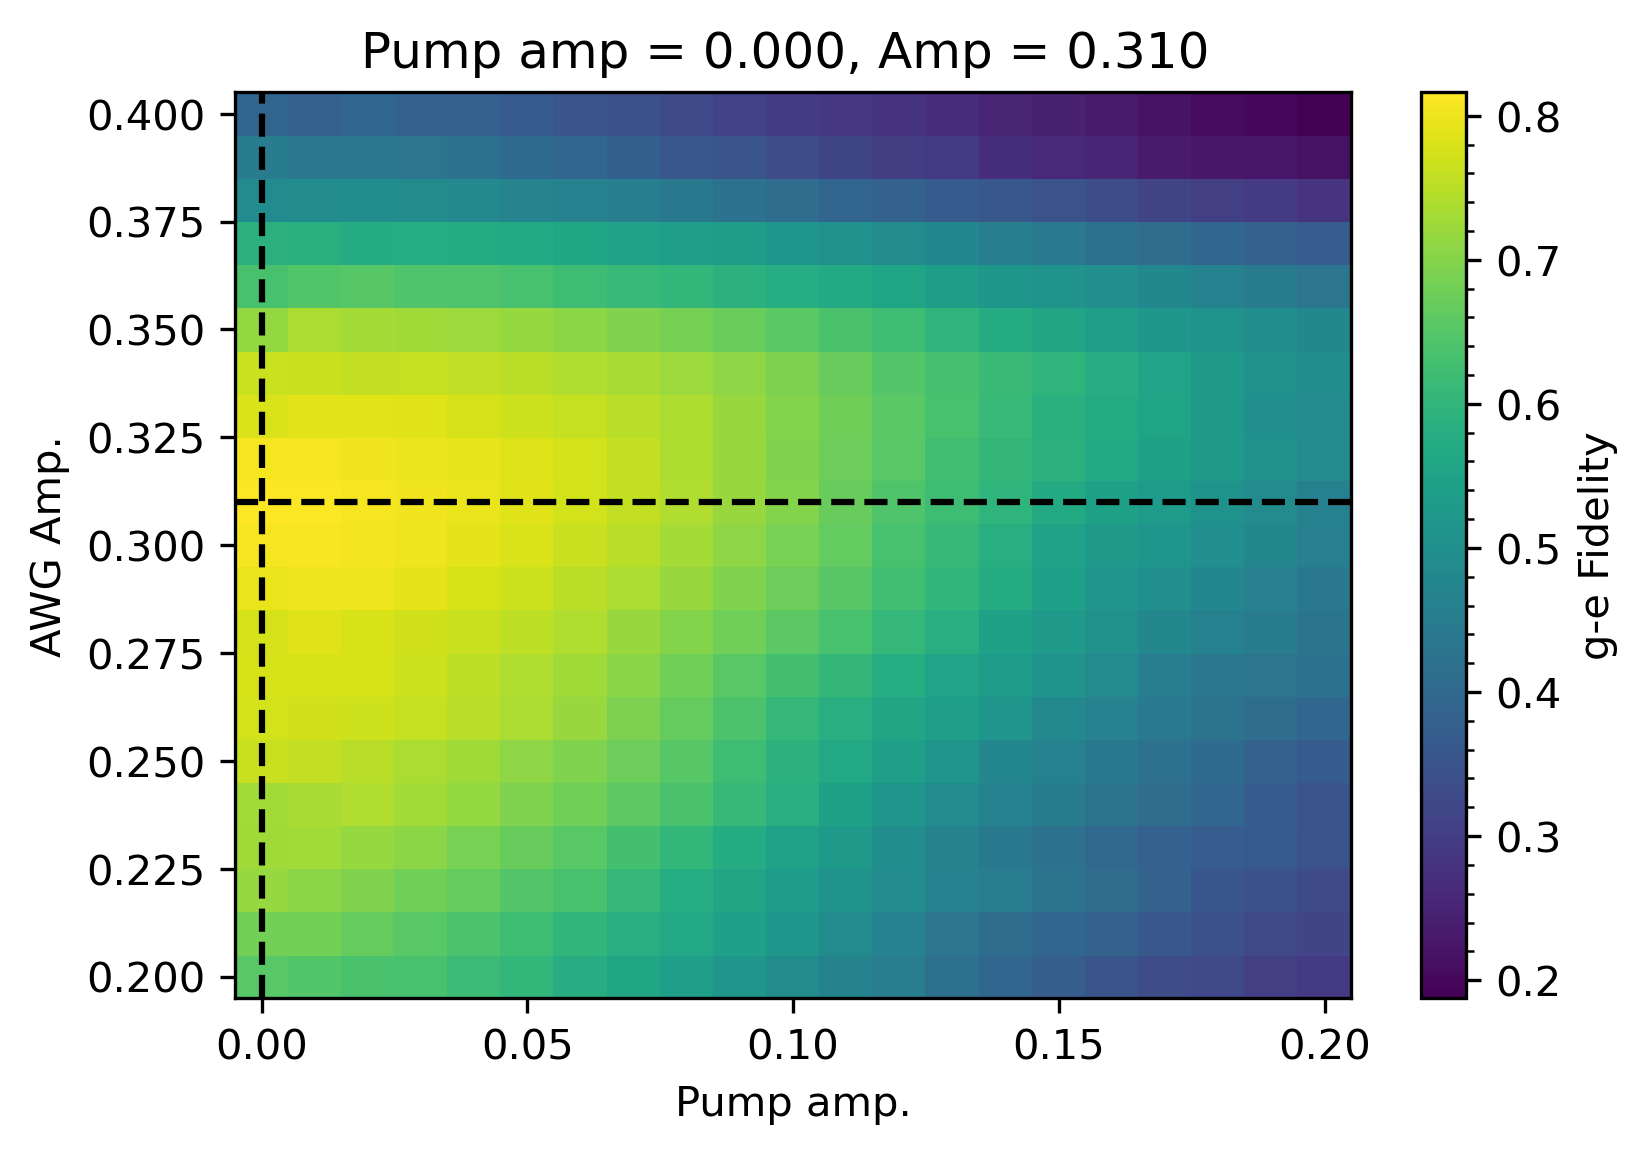

In [203]:
expt_name = 'histogram_jpa_rr_amp_sweep'
filelist = [0]
#1- 3us long
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        pamp = array(a['pamp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs], Qg.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs]
        ie, qe = Ie.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs], Qe.iloc[ii*len(pamp)*avgs: (ii+1)*len(pamp)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(pamp)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.2)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(pamp, amp, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'Pump amp = %.3f, Amp = %.3f '%(pamp[ind%len(pamp)], amp[ind//len(pamp)]))
    plt.xlabel(r'Pump amp.')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = pamp[ind%len(pamp)]/1e6, linestyle='--', color='k')
    plt.axhline(y = amp[ind//len(pamp)], linestyle='--', color='k')
    plt.show()

## JPA

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:183: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.602
Optimal fidelity after rotation = 0.920


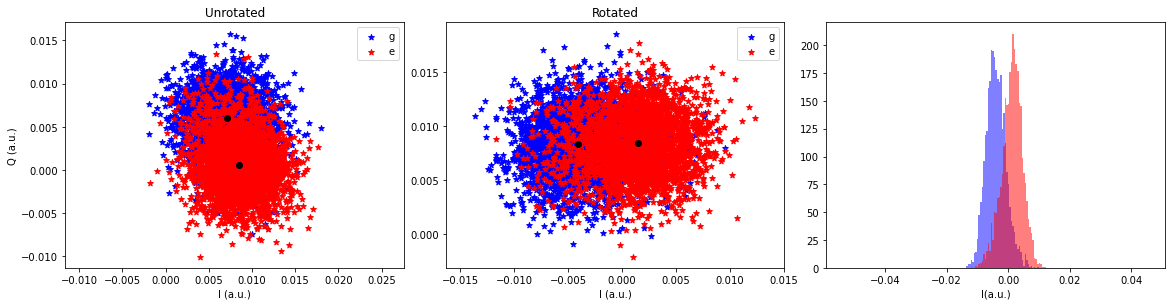

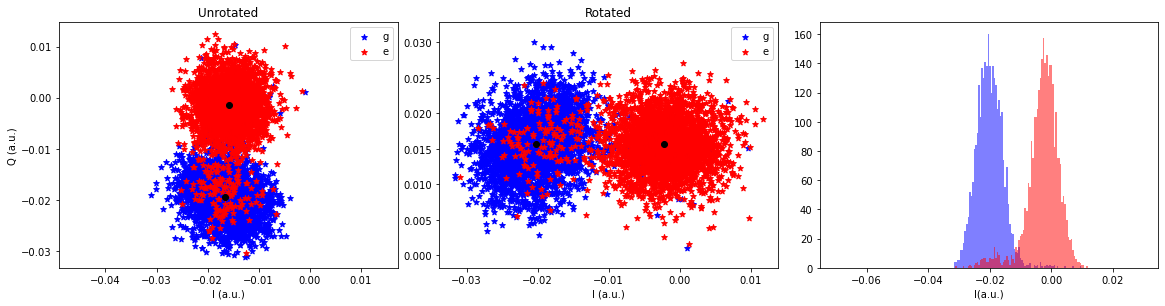

In [655]:
expt_name = 'histogram_jpa'
filelist = [4, 136]
#43 - 2μs 
#24 - 1μs and 0.5*rramp
for ii, i in enumerate(filelist[::-1]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        fid, angle = hist(filename, data=None, plot=True, ran=0.05)

    print('Optimal fidelity after rotation = %.3f'%fid)

### JPA freq and amp sweep, 4μs

(12663000,)
1407 0.8343333333333334


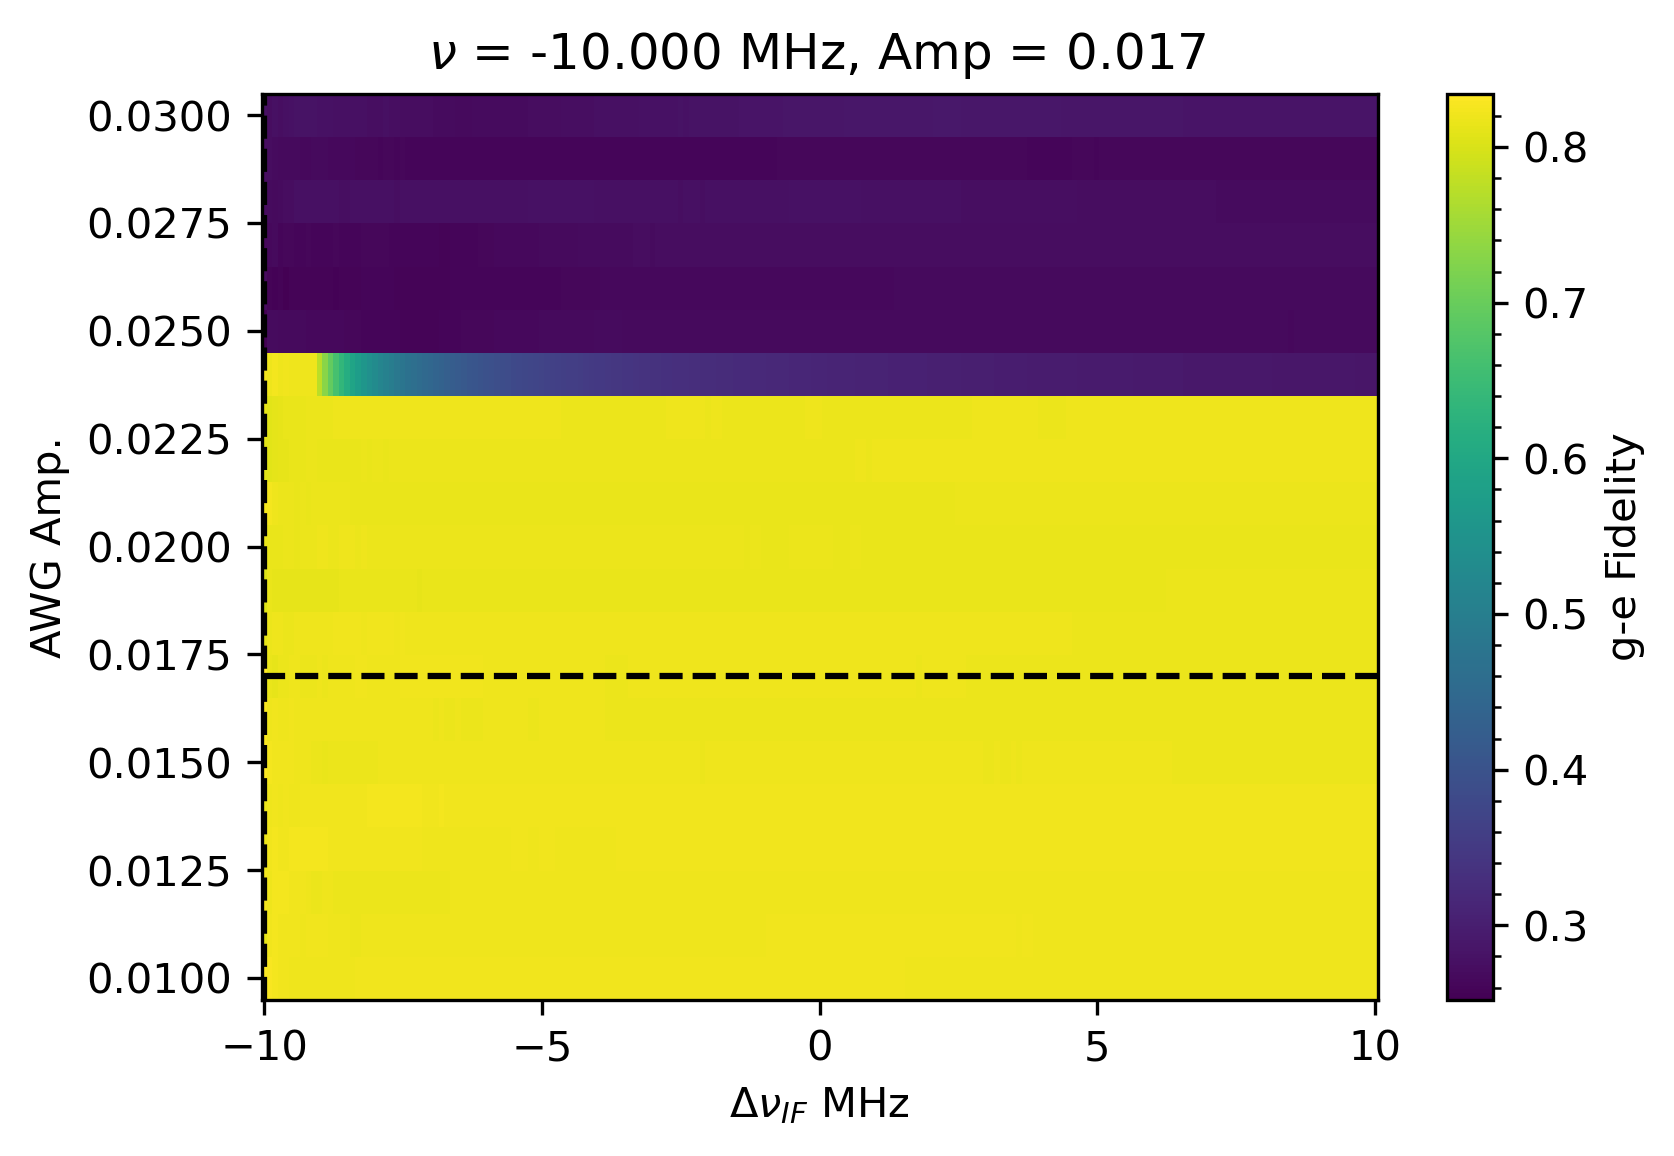

In [388]:
expt_name = 'histogram_jpa_freq_amp_sweep'
filelist = [4]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=0.005)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)
        
    ind = np.argmax(fid_f_p)
    fid_max = np.max(fid_f_p)
    print(ind, fid_max)

    plt.figure(dpi=300)
    plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
    cbar = plt.colorbar()
    cbar.minorticks_on()
    cbar.set_label('g-e Fidelity')
    plt.title(r'$\nu$ = %.3f MHz, Amp = %.3f '%(freqs[ind%len(freqs)]/1e6, attens[ind//len(freqs)]))
    plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
    plt.ylabel('AWG Amp.')
    plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
    plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
    plt.show()

0 0.8126666666666666


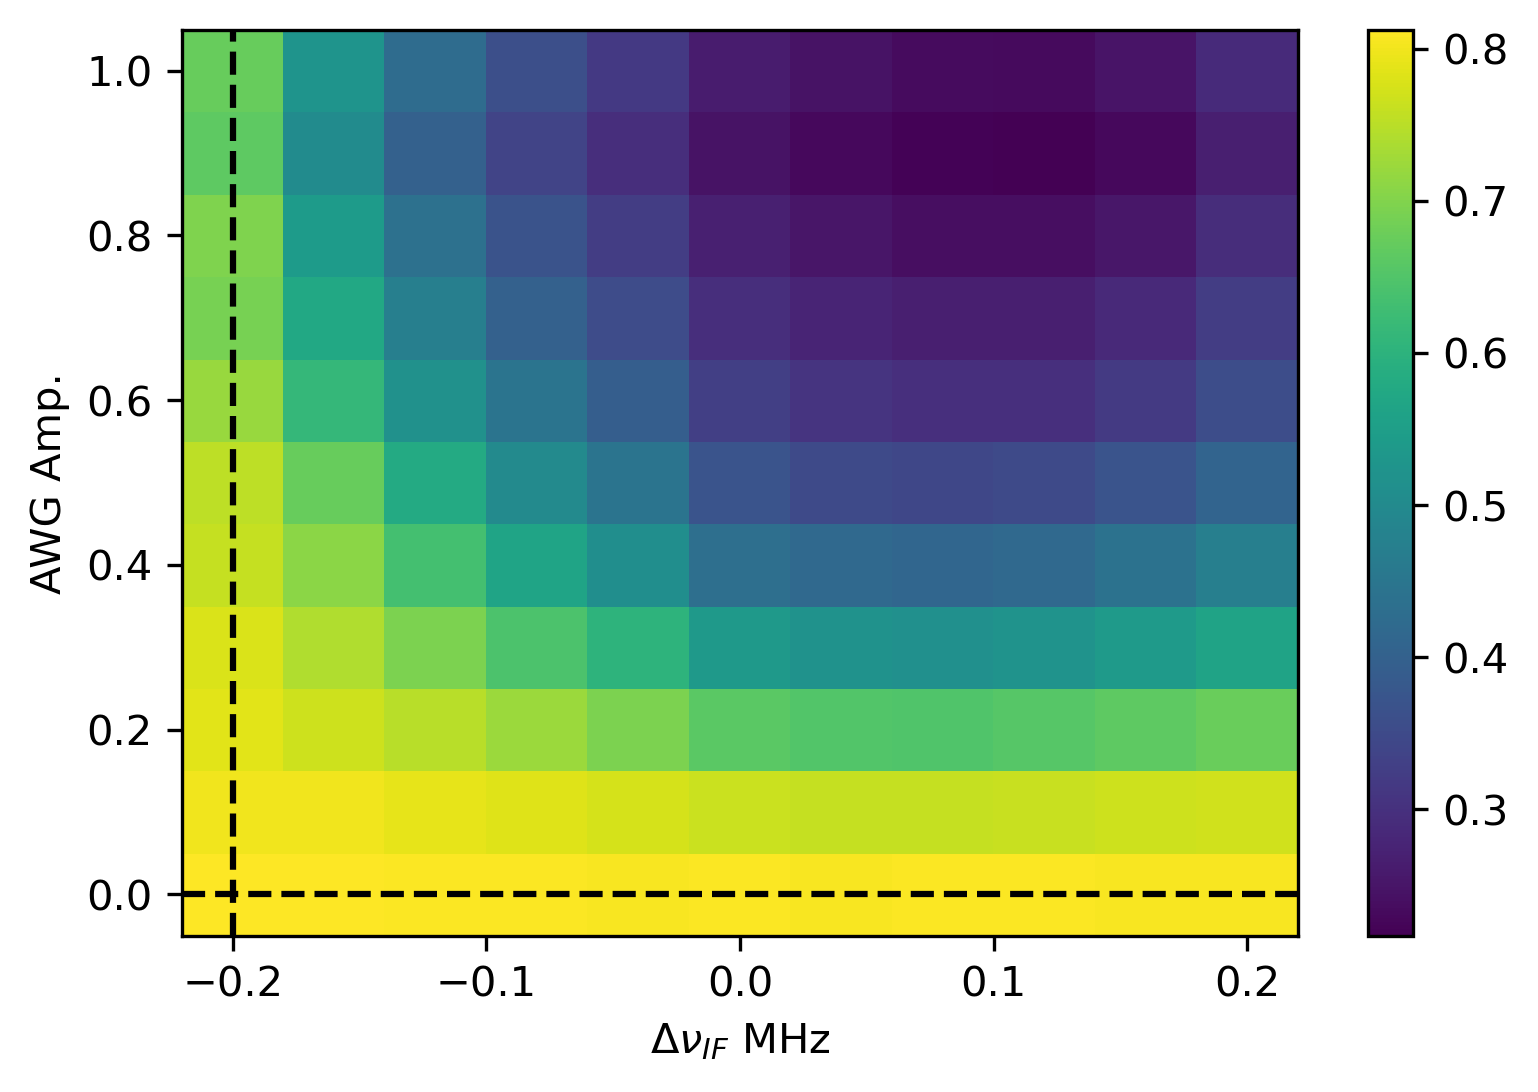

In [5]:
ind = np.argmax(fid_f_p)
fid_max = np.max(fid_f_p)
print(ind, fid_max)
plt.figure(dpi=300)
plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
plt.colorbar()
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('AWG Amp.')
plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
plt.show()


### Amp sweep

(33000,)


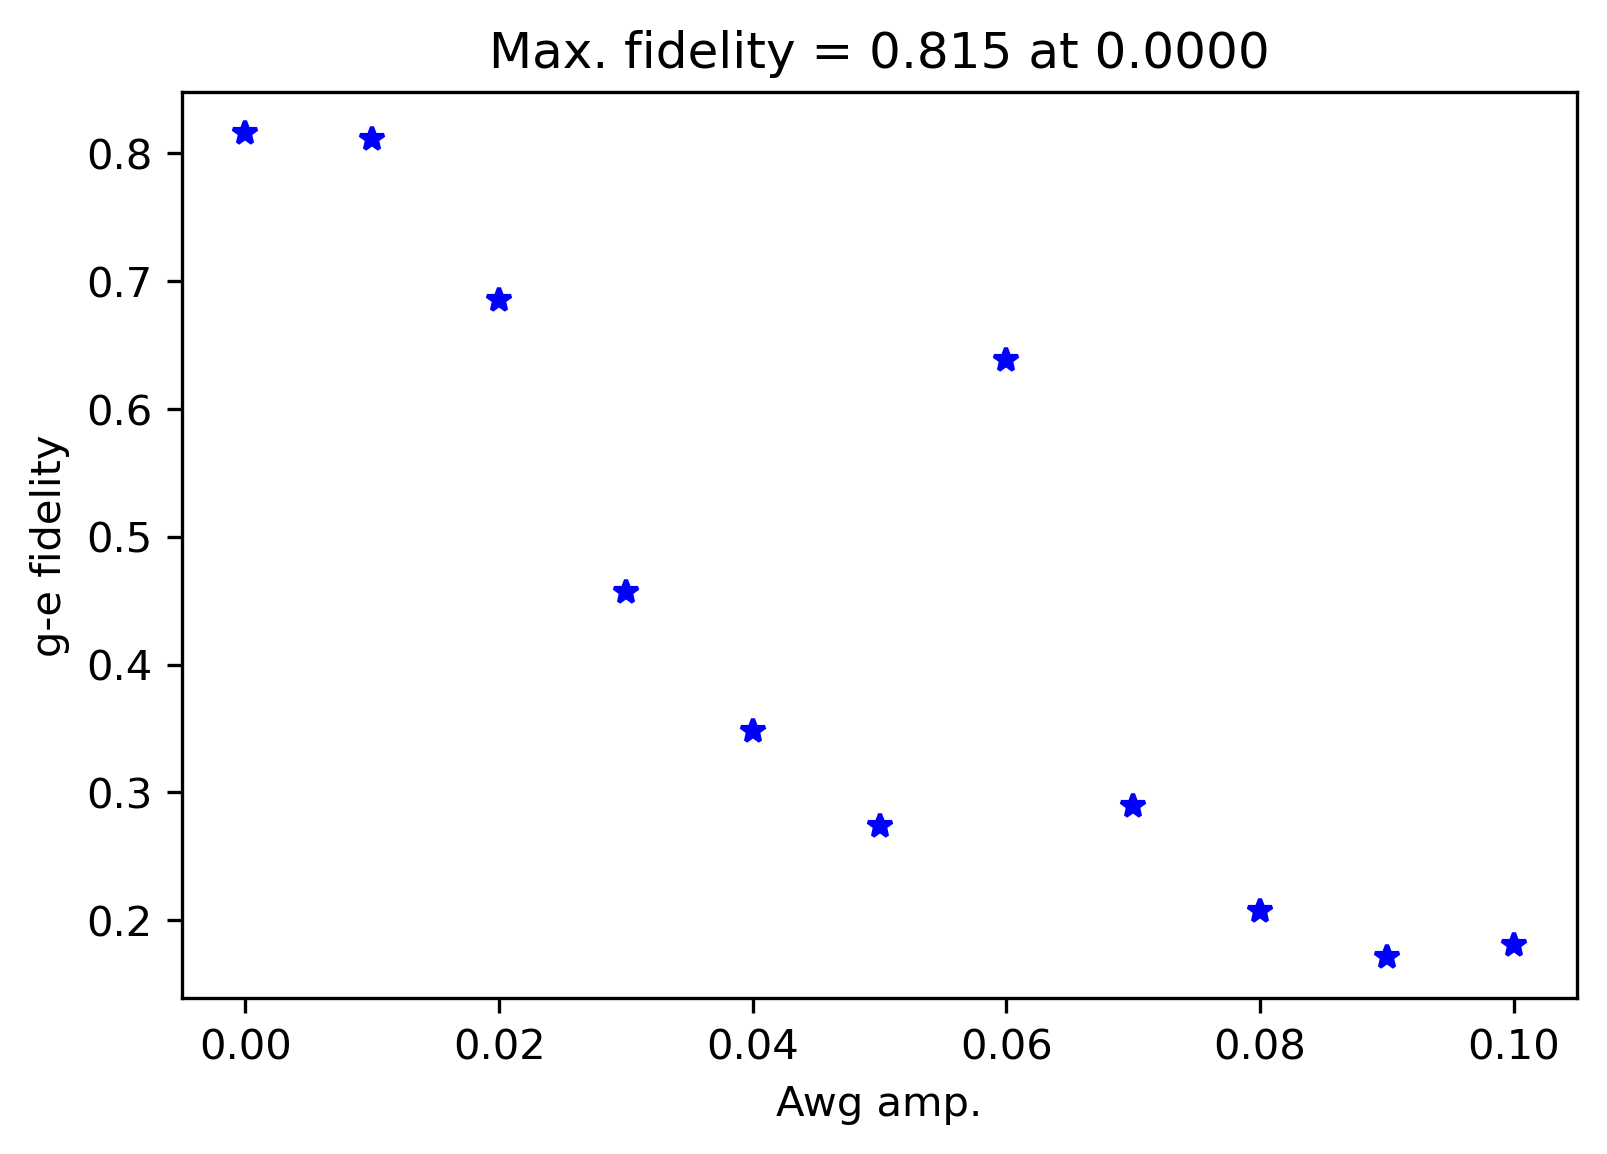

0.8153333333333334


In [368]:
expt_name = 'histogram_jpa_amp_sweep'
filelist = [6]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        amp = array(a['amp'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(amp)):
        """Select all the rows corresponding to the same readout power"""
        a, b = Ig.iloc[ii*avgs: (ii+1)*avgs], Qg.iloc[ii*avgs: (ii+1)*avgs]
        c, d = Ie.iloc[ii*avgs: (ii+1)*avgs], Qe.iloc[ii*avgs: (ii+1)*avgs]
        data = [a, b, c, d]
        fid, angle = hist(filename=None, data=data, plot=False, ran=0.005)
        fid_f_p.append(fid)

    plt.figure(dpi=300)
    plt.plot(amp, fid_f_p, 'b*')
    plt.title('Max. fidelity = %.3f at %.4f'%(max(fid_f_p), amp[np.argmax(fid_f_p)]))
    plt.xlabel('Awg amp.')
    plt.ylabel('g-e fidelity')
    plt.show()
    print(max(fid_f_p))

## JPA freq and amp sweep, 3 μs

In [118]:
expt_name = 'histogram_jpa_freq_amp_sweep'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ig = array(a['ig'])
        Qg = array(a['qg'])
        Ie = array(a['ie'])
        Qe = array(a['qe'])
        attens = 0.035*array(a['amp'])
        freqs = array(a['freq'])
        print(shape(Ig))
        a.close()
        
    Ig = pd.DataFrame(Ig)
    Qg = pd.DataFrame(Qg)
    Ie = pd.DataFrame(Ie)
    Qe = pd.DataFrame(Qe)
    
    fid_f_p = []
    """The sweep occurs in the following order: for a fixed readout frequency, the power is swept
        and then to next readout frequency. So, the data is arranged such that first len(attens) rows correspond to
        one readout frequency.  
        """
    avgs = 3000
    for ii in range(len(attens)):
        """Select all the rows corresponding to the same readout power"""
        ig, qg = Ig.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qg.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        ie, qe = Ie.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs], Qe.iloc[ii*len(freqs)*avgs: (ii+1)*len(freqs)*avgs]
        fid_freq = []
        """For the same readout power, compute the g|e fidelity corresponding to each readout frequency"""
        for jj in range(len(freqs)):
            a = ig.iloc[jj:(jj+1)*avgs]
            b = qg.iloc[jj:(jj+1)*avgs]
            c = ie.iloc[jj:(jj+1)*avgs]
            d = qe.iloc[jj:(jj+1)*avgs]
            data = [a, b, c, d]
            fid, angle = hist(filename=None, data=data, plot=False, ran=1)
            fid_freq.append(fid)
        fid_f_p.append(fid_freq)

(123000,)


ValueError: supplied range of [nan, nan] is not finite

In [116]:
np.shape(fid_f_p)

(1, 41)

In [ ]:
plt.figure(dpi=300)
plt.pcolormesh(freqs/1e6, attens, fid_f_p, shading='auto')
plt.colorbar()
plt.xlabel(r'$\Delta \nu_{IF}$ MHz')
plt.ylabel('AWG Amp.')
plt.axvline(x = freqs[ind%len(freqs)]/1e6, linestyle='--', color='k')
plt.axhline(y = attens[ind//len(freqs)], linestyle='--', color='k')
plt.show()
ind = np.argmax(fid_f_p)
fid_max = np.max(fid_f_p)
print(ind, fid_max)

## CLEAR 

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:183: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Optimal fidelity after rotation = 0.539
Optimal fidelity after rotation = 0.597
Optimal fidelity after rotation = 0.644


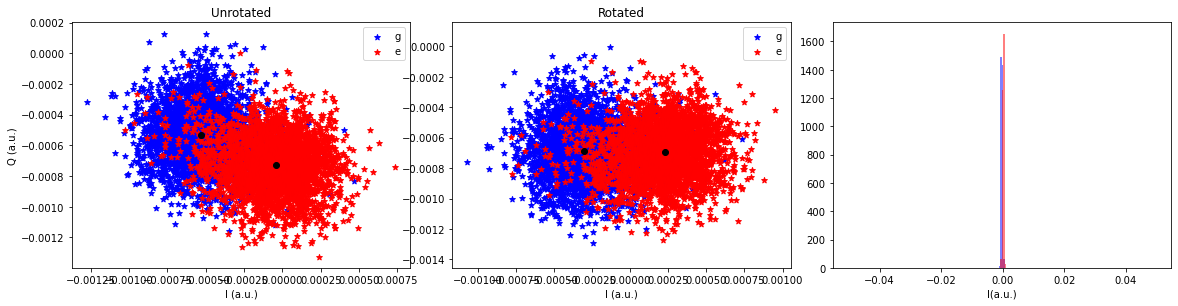

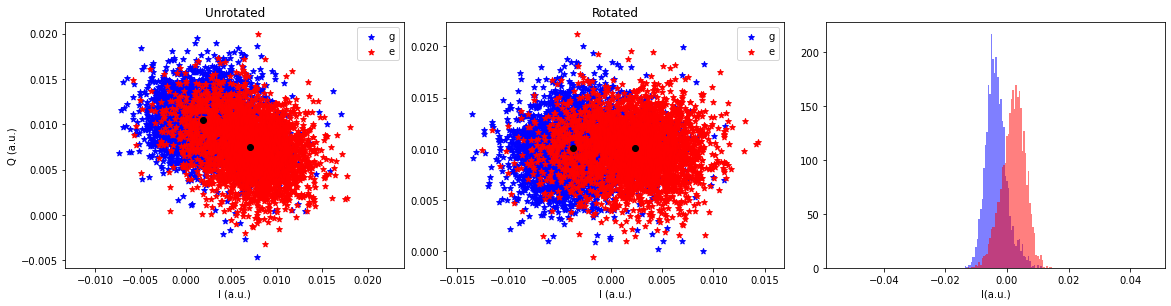

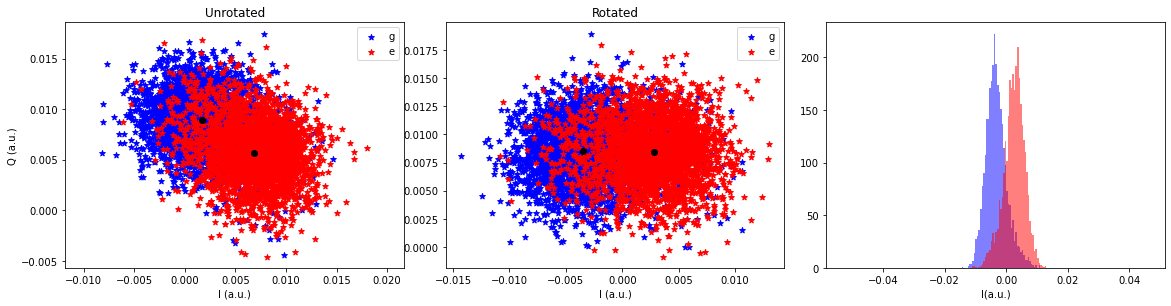

In [663]:
expt_name = 'histogram_clear'
filelist = [27, 30, 31]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    fid, angle = hist(filename, data=None,  plot=True, ran=0.05)

    print('Optimal fidelity after rotation = %.3f'%fid)

# Storage

10


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\slab\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


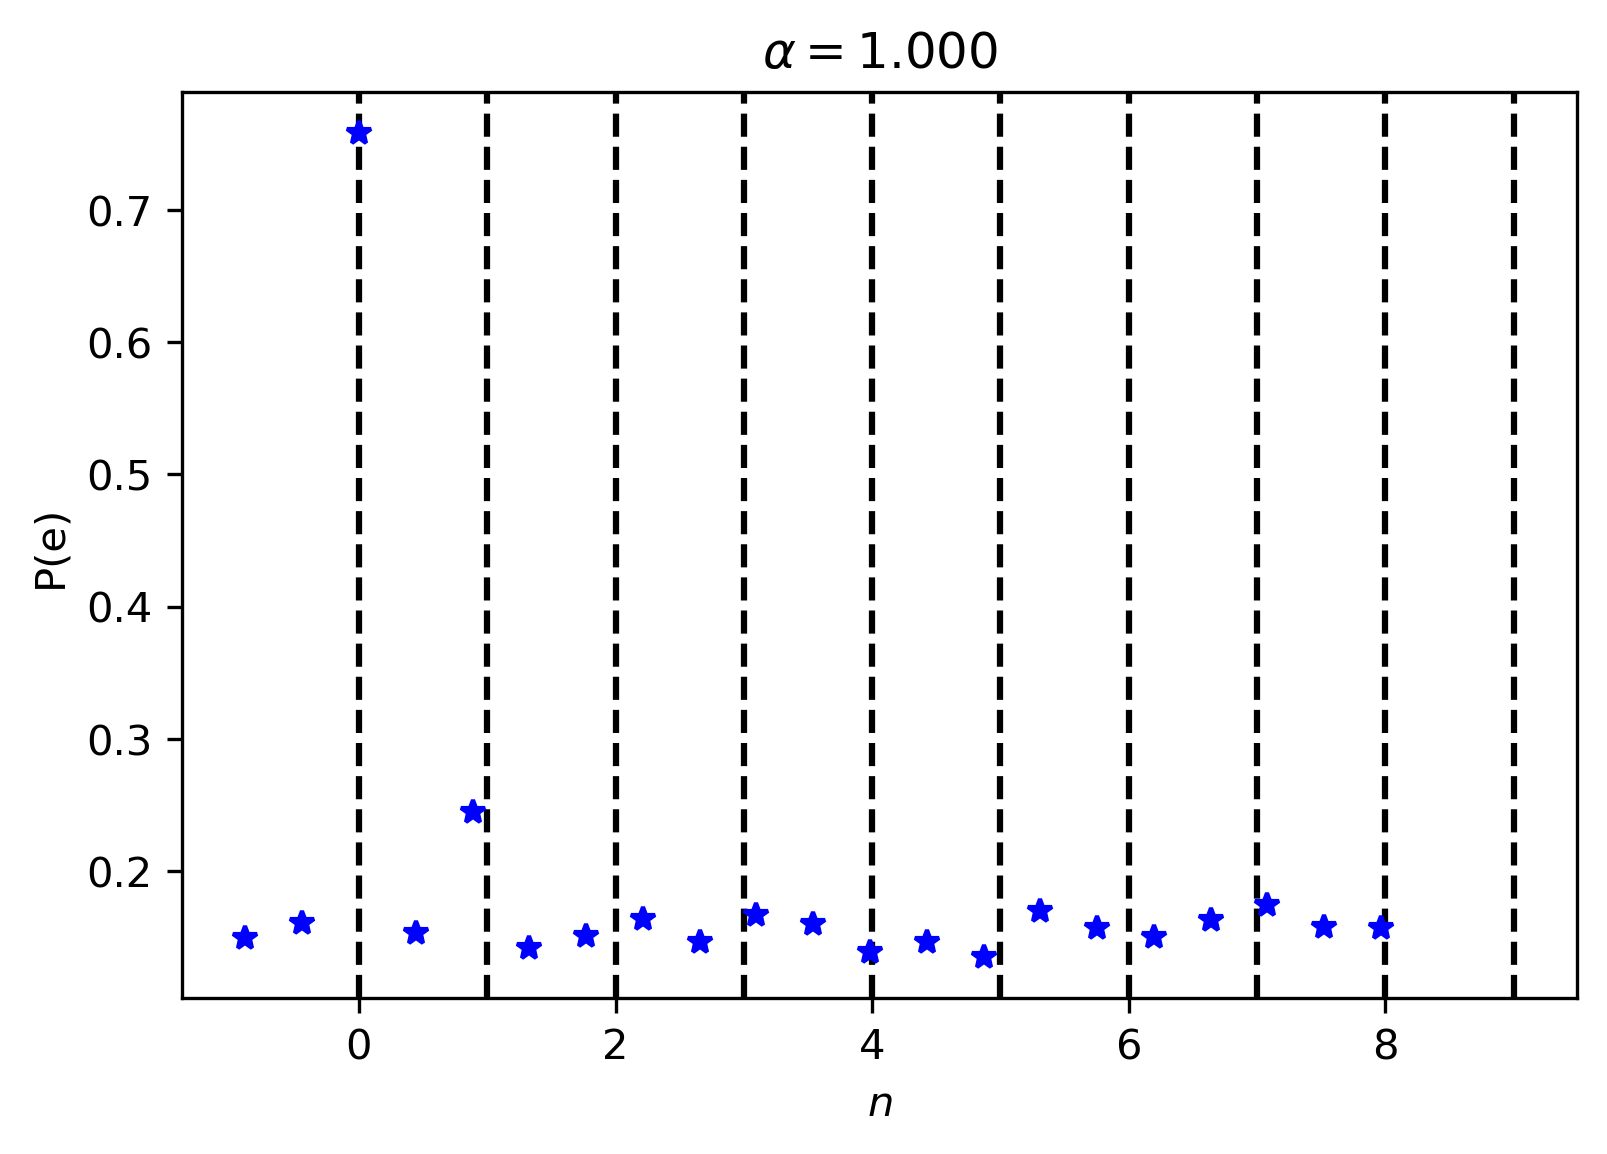

In [533]:
expt_name = 'number_splitting'
filelist = [15]

qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:][::10]
        Q = np.array(a['Q'])[:][::10]
        freqs = (np.array(a['freq'])/1e9- qubit_freq)[:][::10]*1e9/two_chi
        print(n_max)

        a.close()
        
#         x = np.arange(0, n_max, len(Q))
        x = freqs
        y = Q
        plt.figure(dpi=300)
        for j in range(n_max):
            plt.axvline(x=j, linestyle='--', color='k')
        plt.plot(x, y, 'b*')
        popt, pcov = curve_fit(coherent_state, x, y)
        plt.title(r'$\alpha = %.3f$'%popt[1])
#         print(popt)
        plt.ylabel('P(e)')
        plt.xlabel(r'$n$')
#         plt.plot(x, coherent_state(x, *popt), 'r')
        plt.show()


(1, 101)


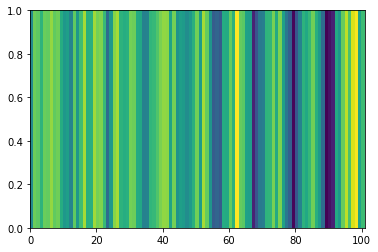

In [570]:
expt_name = 'alpha_cal'
filelist = [3]

qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:][::10]
        freqs = (np.array(a['freq'])/1e9- qubit_freq)[:][::10]*1e9/two_chi
        
    print(np.shape(I))
plt.pcolor(I)

In [531]:
p = fitgausssum_with_baseline(x, y )

print(p)

[ 1.58830112e-01  6.20252409e-01 -4.94320822e-04  1.30236636e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


In [320]:
len(I), len(freq)

(181, 0)

# Readout population

## Optimal shape

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0.8083333333333333 0.3041036341918433


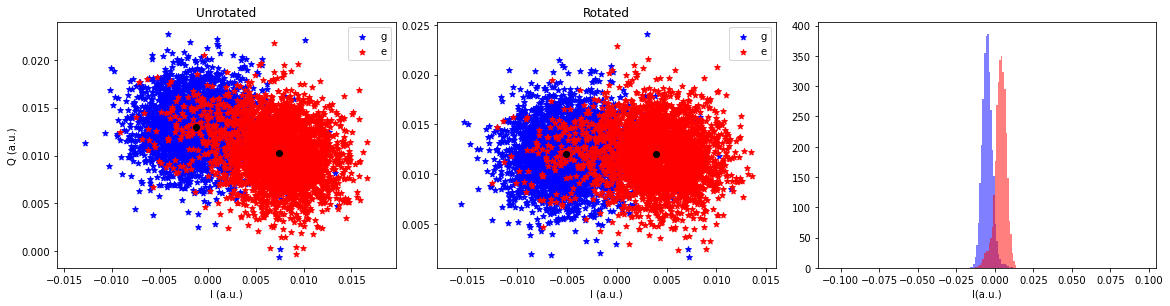

In [392]:
expt_name = 'ramsey_clear'
filelist = [8]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_opt = pd.DataFrame(a['I'])
        Q_opt = pd.DataFrame(a['Q'])
        wait_times_opt = array(a['wait_time'])/1e9
        ramsey_times_opt = array(a['ramsey_times'])/1e9
        
hist_filename = "..\\data\\" + str(122).zfill(5) + "_histogram.h5"
i_rot_opt, q_rot_opt = rot_data(I_opt, Q_opt, hist_filename) 

## Square pulse

C:\Users\slab\Anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0.8083333333333333 0.3041036341918433


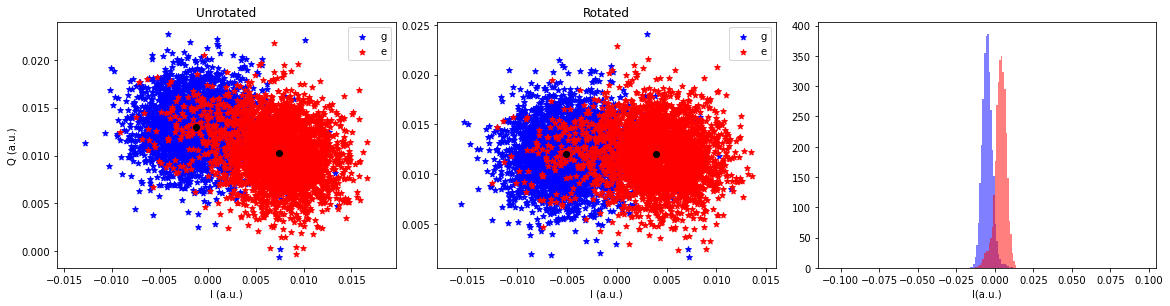

In [393]:
expt_name = 'ramsey_square'
filelist = [2]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I_sq = pd.DataFrame(a['I'])
        Q_sq = pd.DataFrame(a['Q'])
        wait_times_sq = array(a['wait_time'])/1e9
        ramsey_times_sq = array(a['ramsey_times'])/1e9
#9
hist_filename = "..\\data\\" + str(122).zfill(5) + "_histogram.h5"
i_rot_sq, q_rot_sq = rot_data(I_sq, Q_sq, hist_filename) 

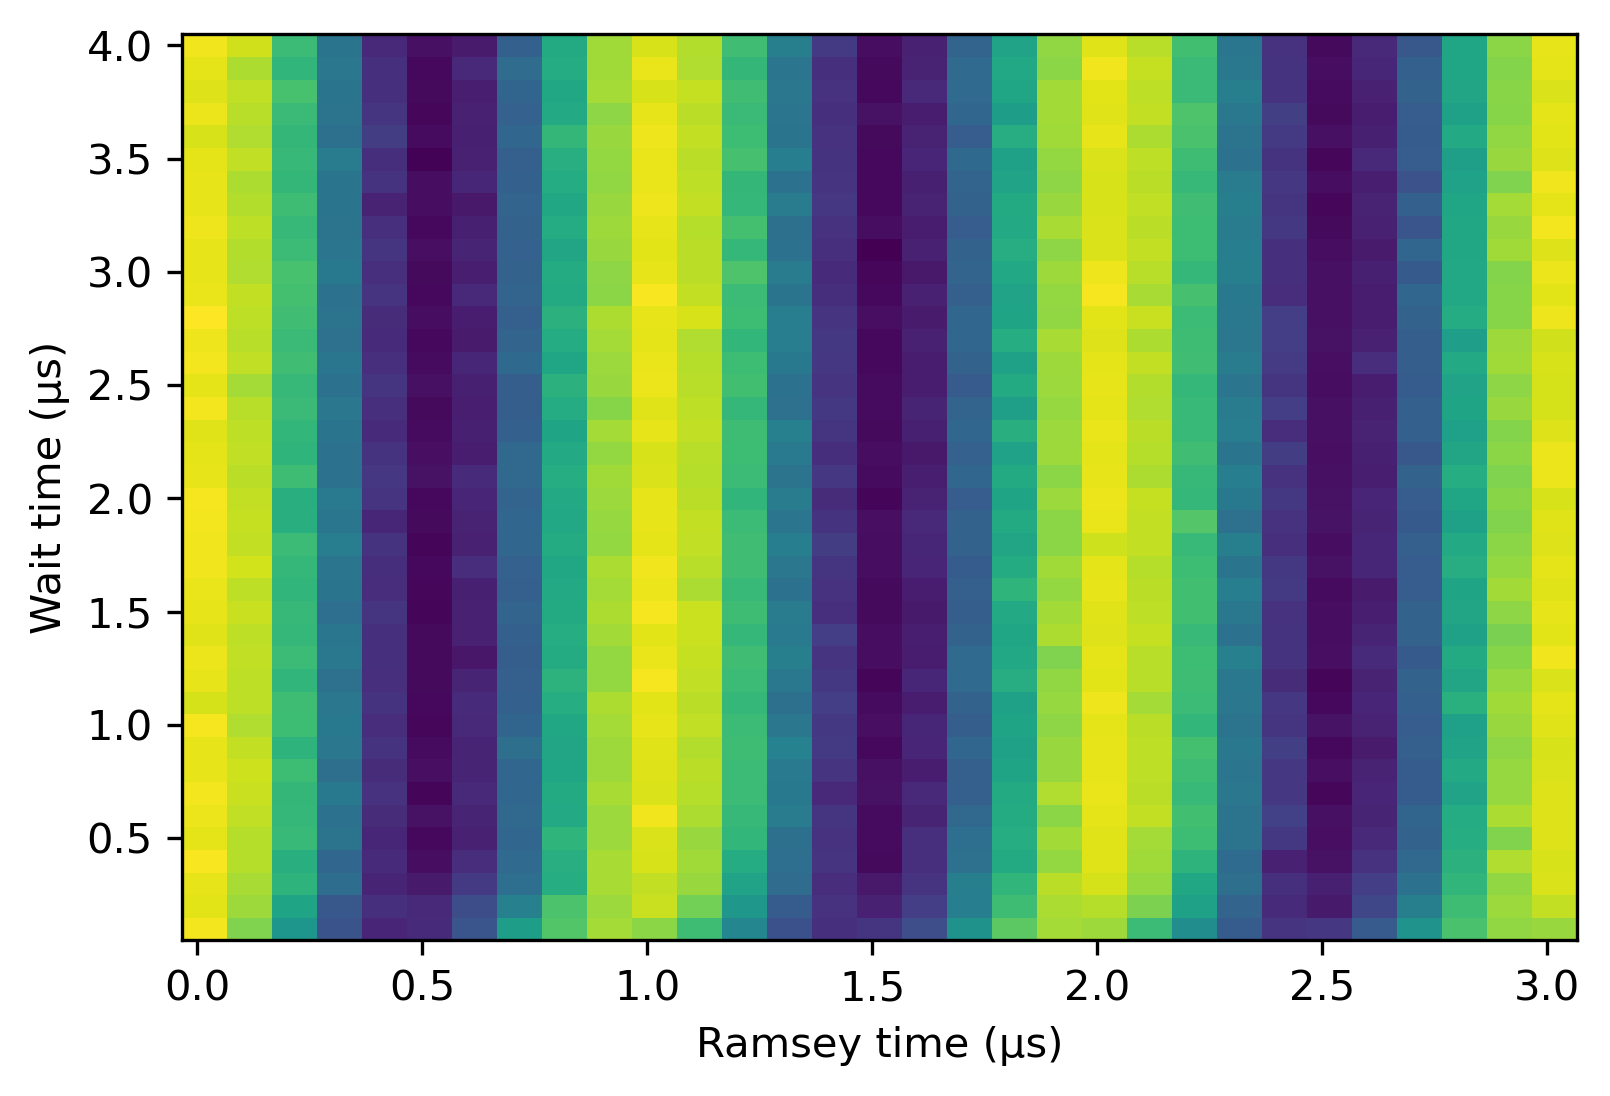

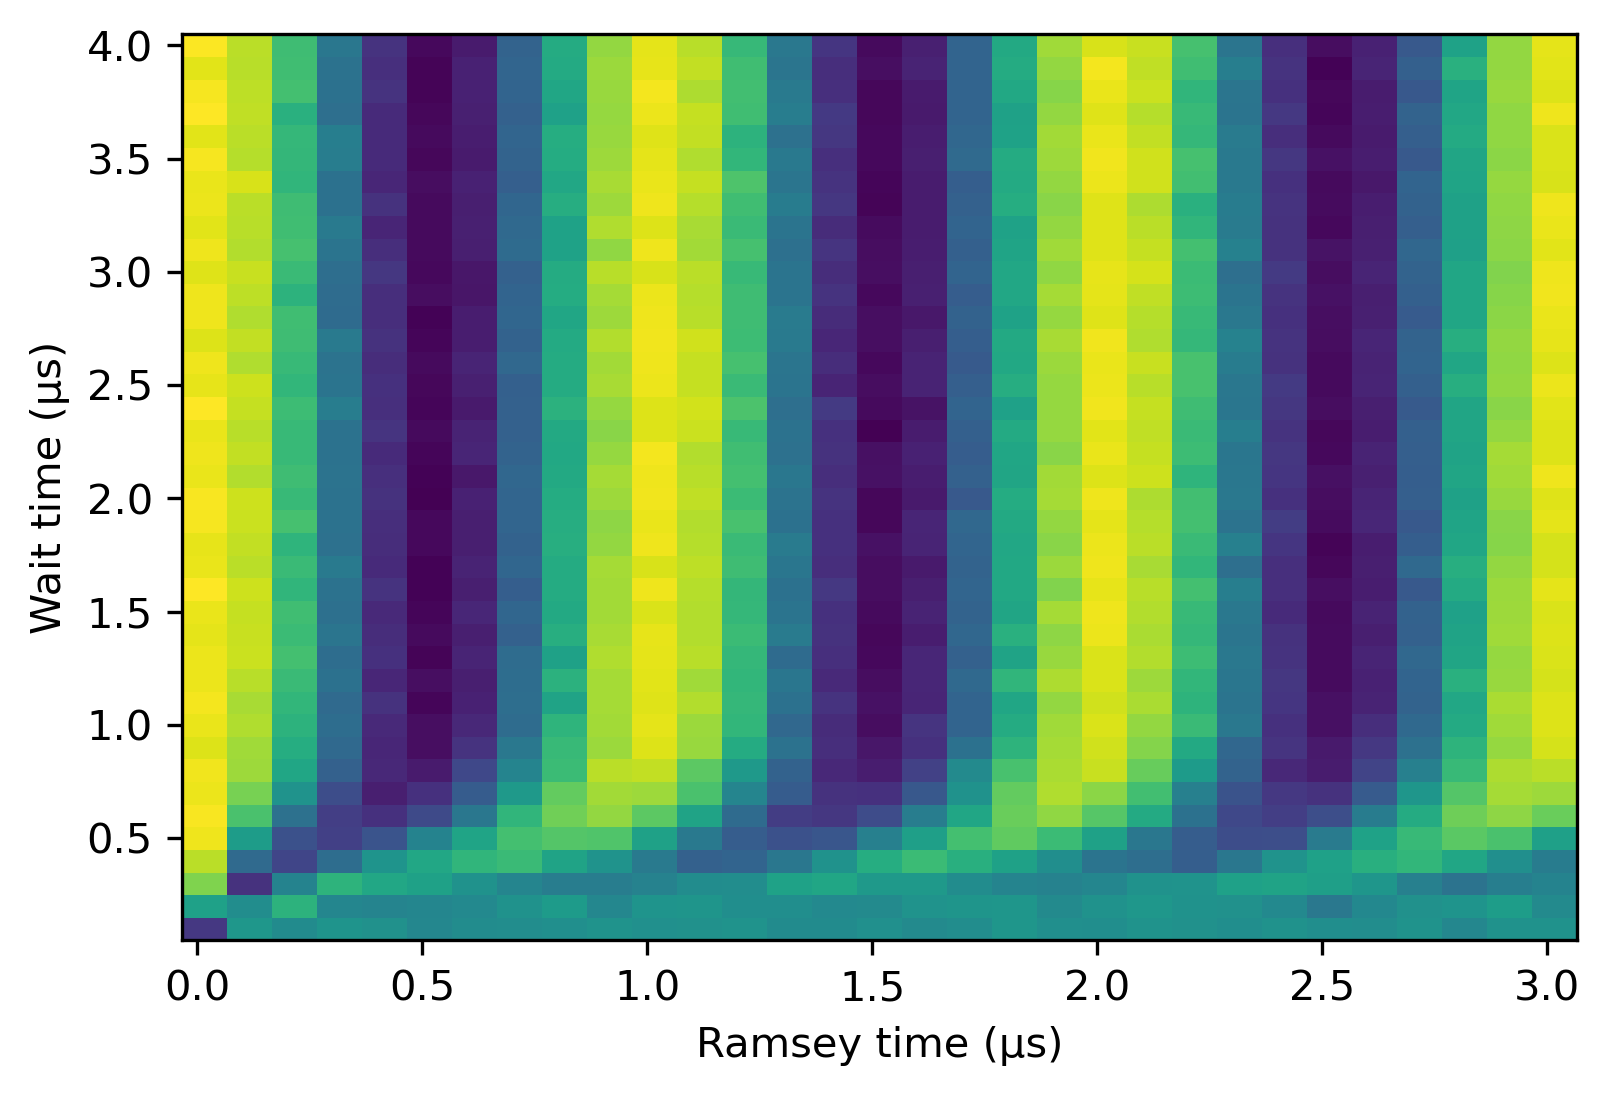

In [394]:
plt.figure(dpi=300)
plt.pcolormesh(ramsey_times_opt*1e6, wait_times_opt*1e6, i_rot_opt, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\opt_pulse_2d_buffer_no_wait_time.png')
plt.show()

plt.figure(dpi=300)
plt.pcolormesh(ramsey_times_sq*1e6, wait_times_sq*1e6, i_rot_sq, shading='auto')
plt.xlabel('Ramsey time (μs)')
plt.ylabel('Wait time (μs)')
# plt.savefig('S:\Morgan\qm_opx\morgan\plots\square_pulse_2d_buffer.png')
plt.show()

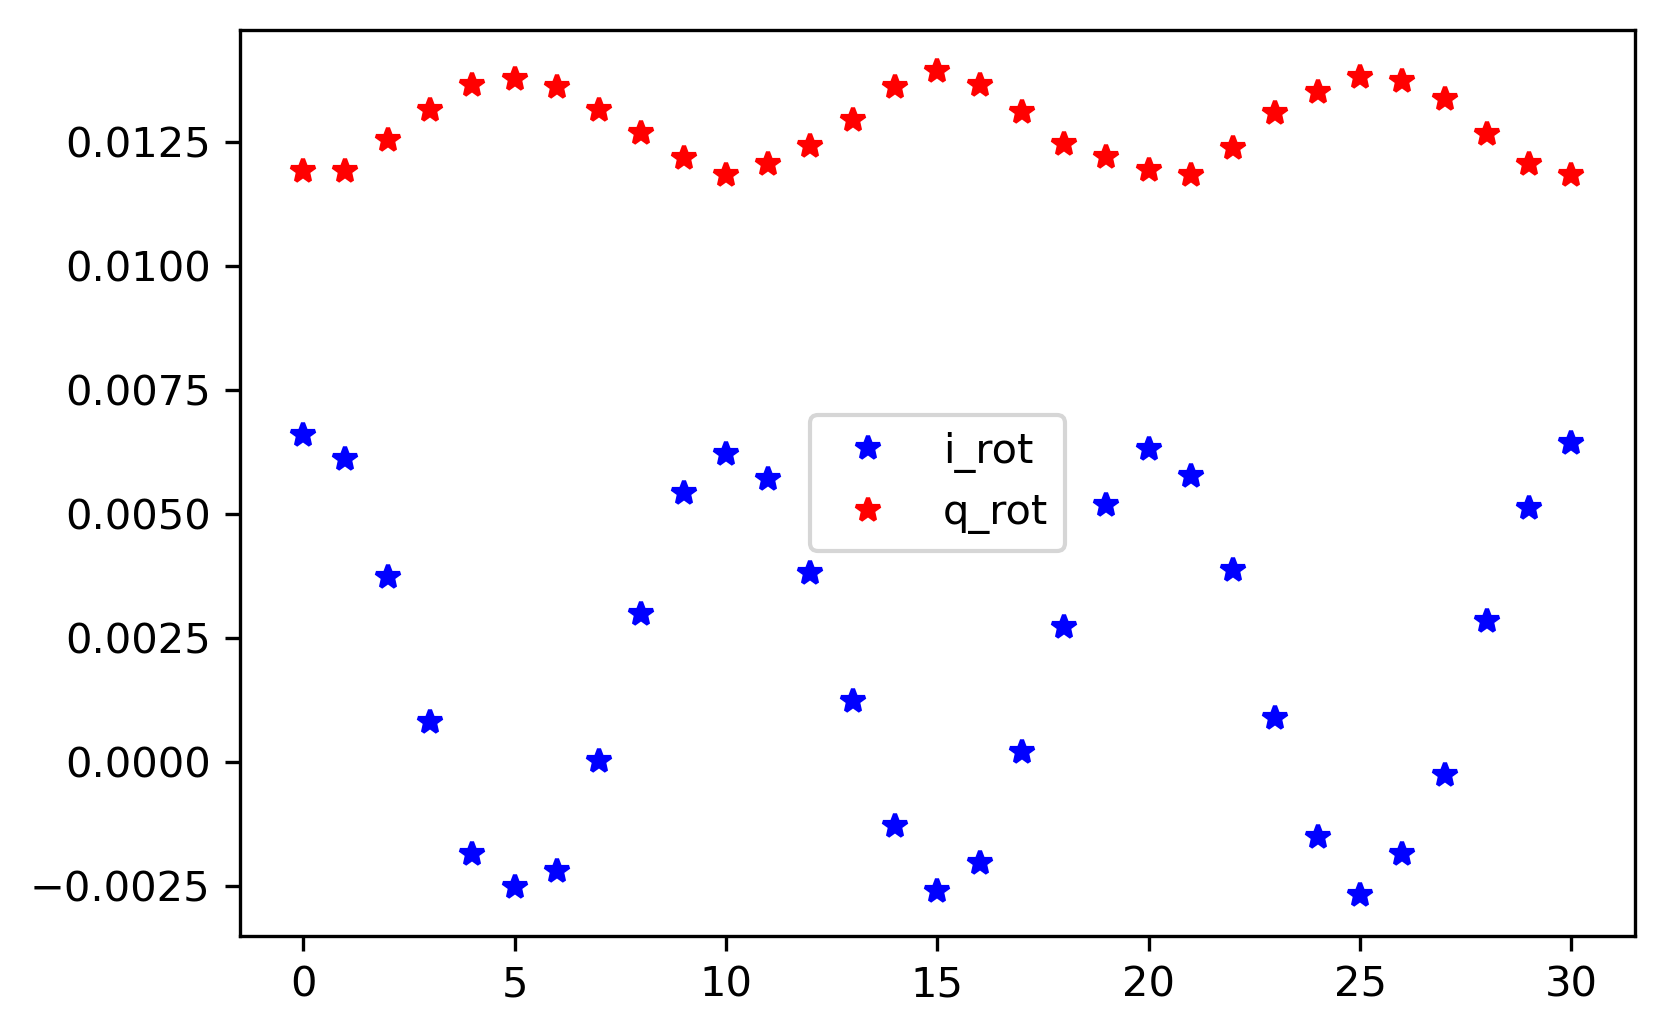

In [286]:
plt.figure(dpi=300)
plt.plot(i_rot_opt.iloc[-1], 'b*', label='i_rot')
plt.plot(q_rot_opt.iloc[-1], 'r*', label='q_rot')
plt.legend()
plt.show()

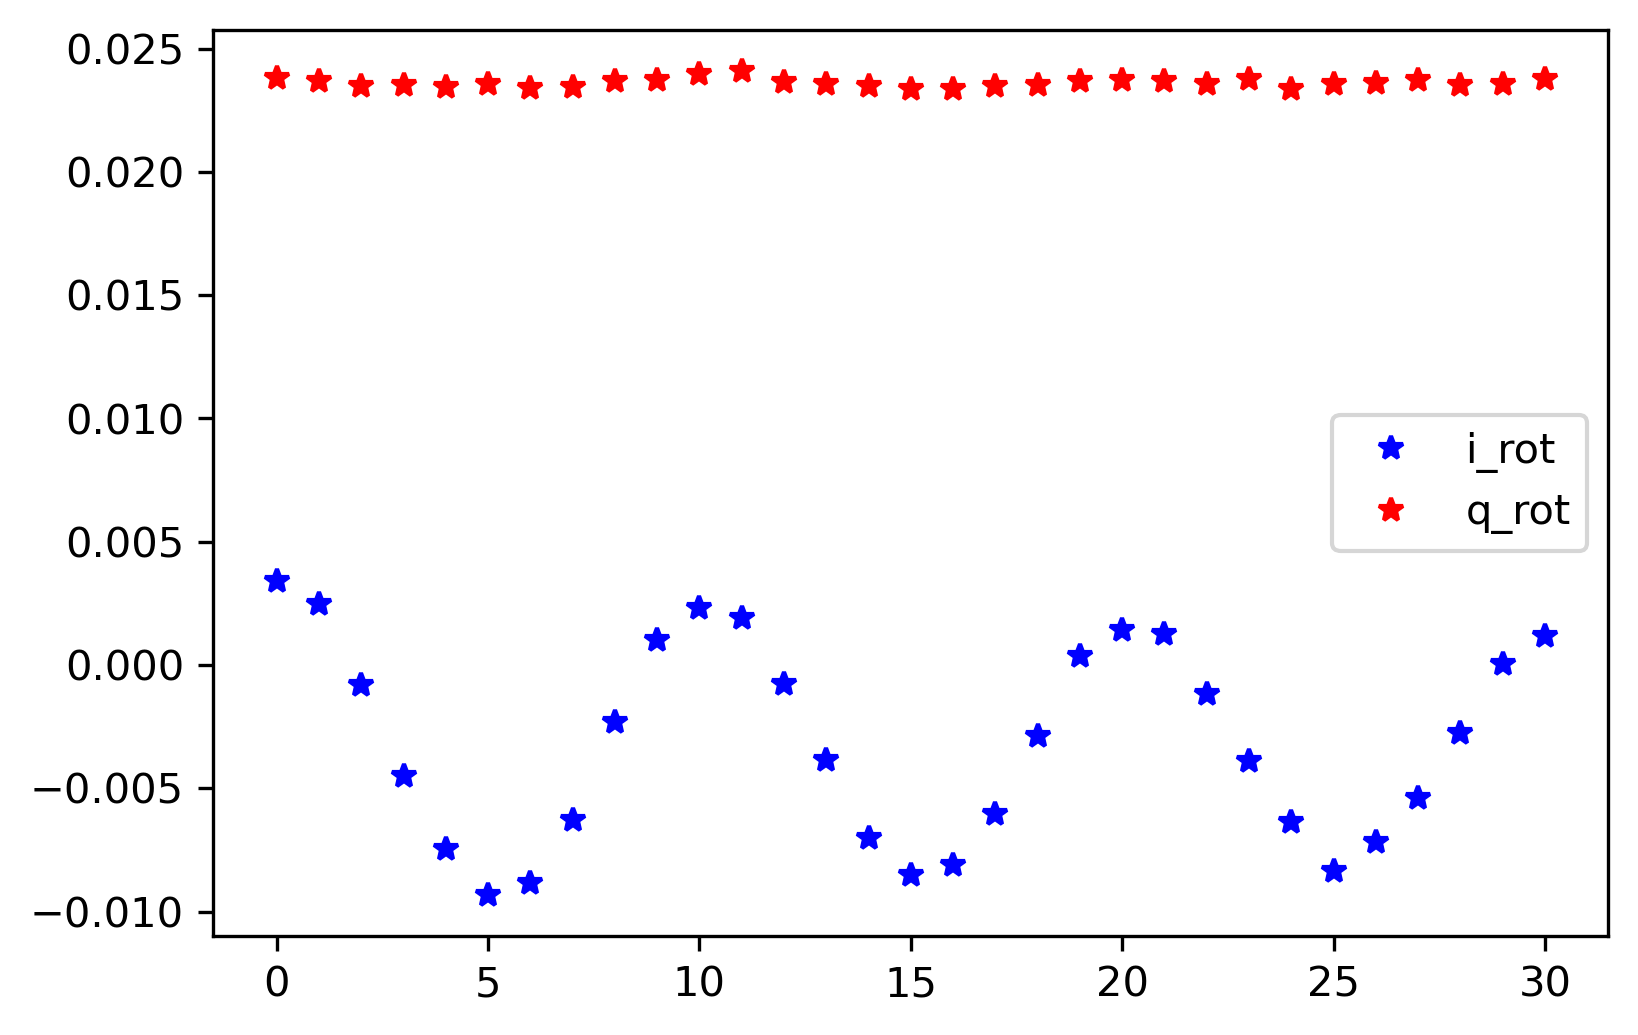

In [130]:
plt.figure(dpi=300)
plt.plot(i_rot_sq.iloc[-1], 'b*', label='i_rot')
plt.plot(q_rot_sq.iloc[-1], 'r*', label='q_rot')
plt.legend()
plt.show()

60.1064008175307


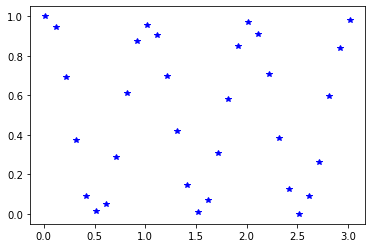

126.9510909108377


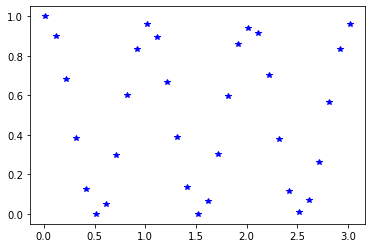

In [302]:
g = min(i_rot_opt.iloc[-1])
e = max(i_rot_opt.iloc[-1])
# g = -0.00952391
# e = 0.00883598

i_cal_opt = abs((i_rot_opt - g))/abs((-g + e))
plt.figure()
plt.plot(ramsey_times_opt*1e6, i_cal_opt.iloc[-1], 'b*')
p = fitdecaysin(ramsey_times_opt*1e6, i_cal_opt.iloc[-1])
print(p[3])
plt.show()


g = min(i_rot_sq.iloc[-1])
e = max(i_rot_sq.iloc[-1])

# g = -0.00936313
# e = 0.00924562
plt.figure()
i_cal_sq = (i_rot_sq - g)/(-g + e)
plt.plot(ramsey_times_sq*1e6, i_cal_sq.iloc[-1], 'b*')
p = fitdecaysin(ramsey_times_sq*1e6, i_cal_sq.iloc[-1])
print(p[3])
plt.show()

0.001930362852654799


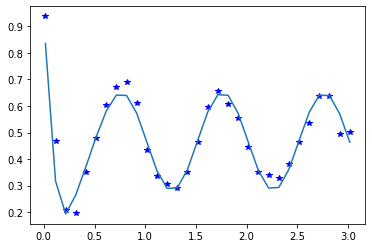

[ 2.23901895 10.60935969  0.93282584]


In [132]:
x_data = ramsey_times
y_data = i_cal_sq.iloc[8]

plt.figure()
plt.plot(x_data*1e6, y_data, 'b*')
popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])

plt.plot(x_data*1e6, ramsfit(x_data, popt[0], popt[1], popt[2]))
print(p[3])
plt.show()
print(popt)

C:\Users\slab\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


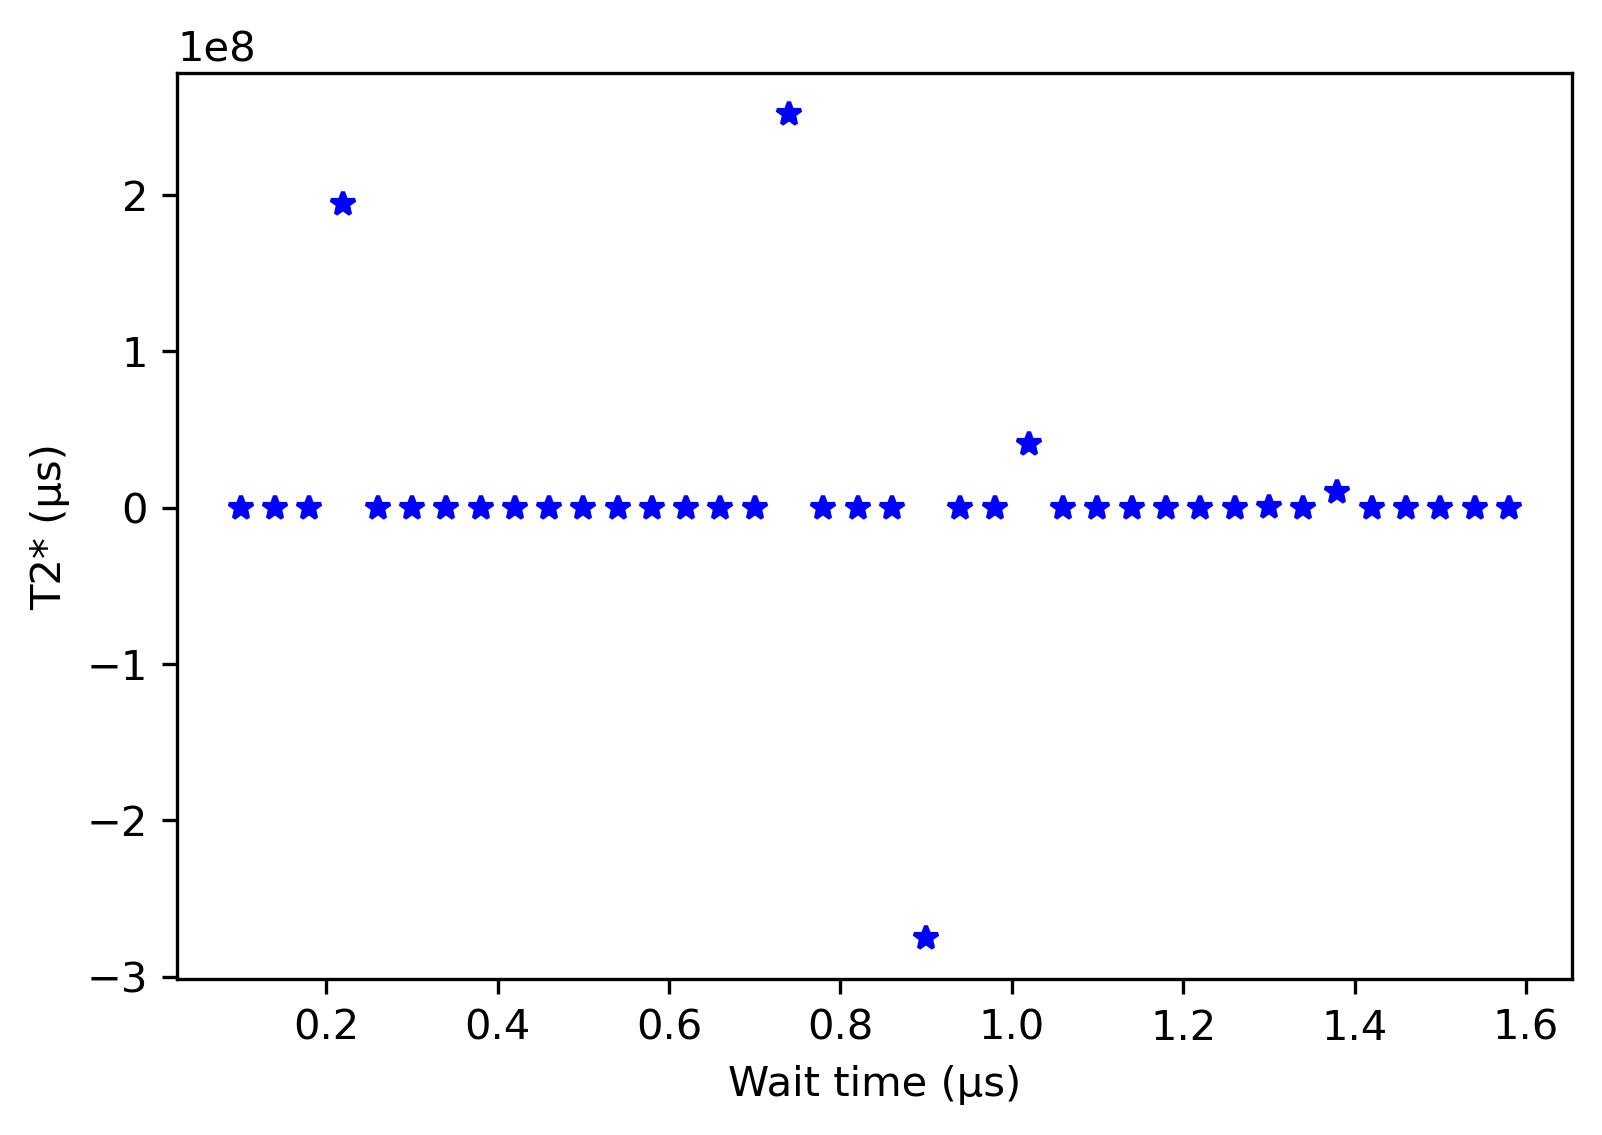

In [133]:
t2_wait = []
for i in range(len(wait_times)):
    x = np.array(ramsey_times*1e6)
    y = np.array(i_cal_opt.iloc[i])
    p = fitdecaysin(x, y, showfit=False)
    if p[3] > 200:
        p = fitdecaysin(x[2:-3], y[2:-3], showfit=False)

    t2_wait.append(p[3])
plt.figure(dpi=300)
plt.plot(wait_times*1e6, t2_wait, 'b*')
plt.ylabel('T2* (μs)')
plt.xlabel('Wait time (μs)')
plt.show()

## Comparison

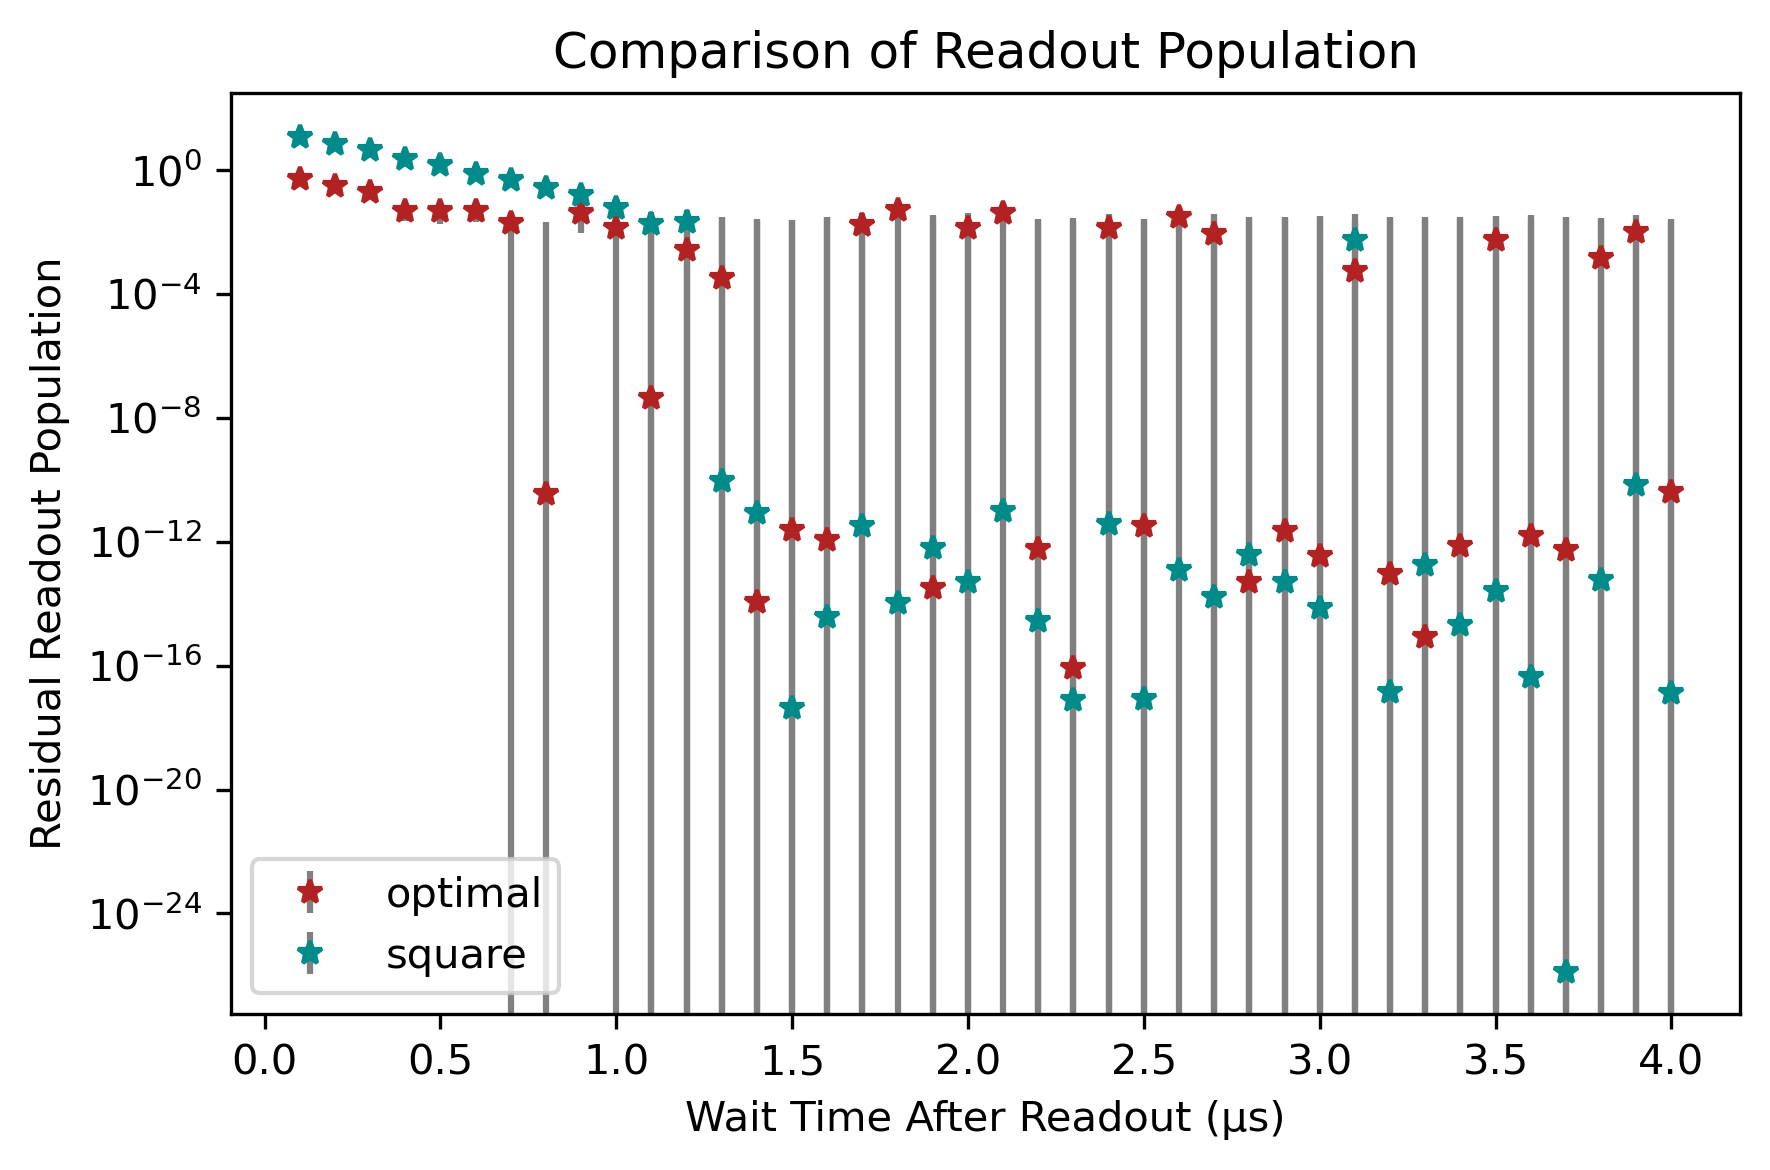

In [333]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data, bounds = (0,[np.inf,2*np.pi,np.inf]))
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))
    
read_popt_square = []
read_popt_error_square = []
for j in range(len(wait_times_sq)):
    y_data = i_cal_sq.iloc[j]
    x_data = ramsey_times_sq
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:],bounds = (0,[np.inf,2*np.pi,np.inf]))
    read_popt_square.append(popt[0])
    read_popt_error_square.append(np.sqrt(np.diag(pcov)[0]))


fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

ax1.errorbar(wait_times_sq*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
             ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')
#ax1.errorbar(wait_times_opt*1e6, read_popt_opt, fmt='*', color='firebrick', ecolor='grey', capthick=2, label='optimal')
#ax1.errorbar(wait_times_sq*1e6, read_popt_square, fmt='*', color='darkcyan', ecolor='grey', capthick=2, label = 'square')
ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
#ax1.set_ylim(-.1, 1)
#ax2.set_ylim(-.1, 1)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

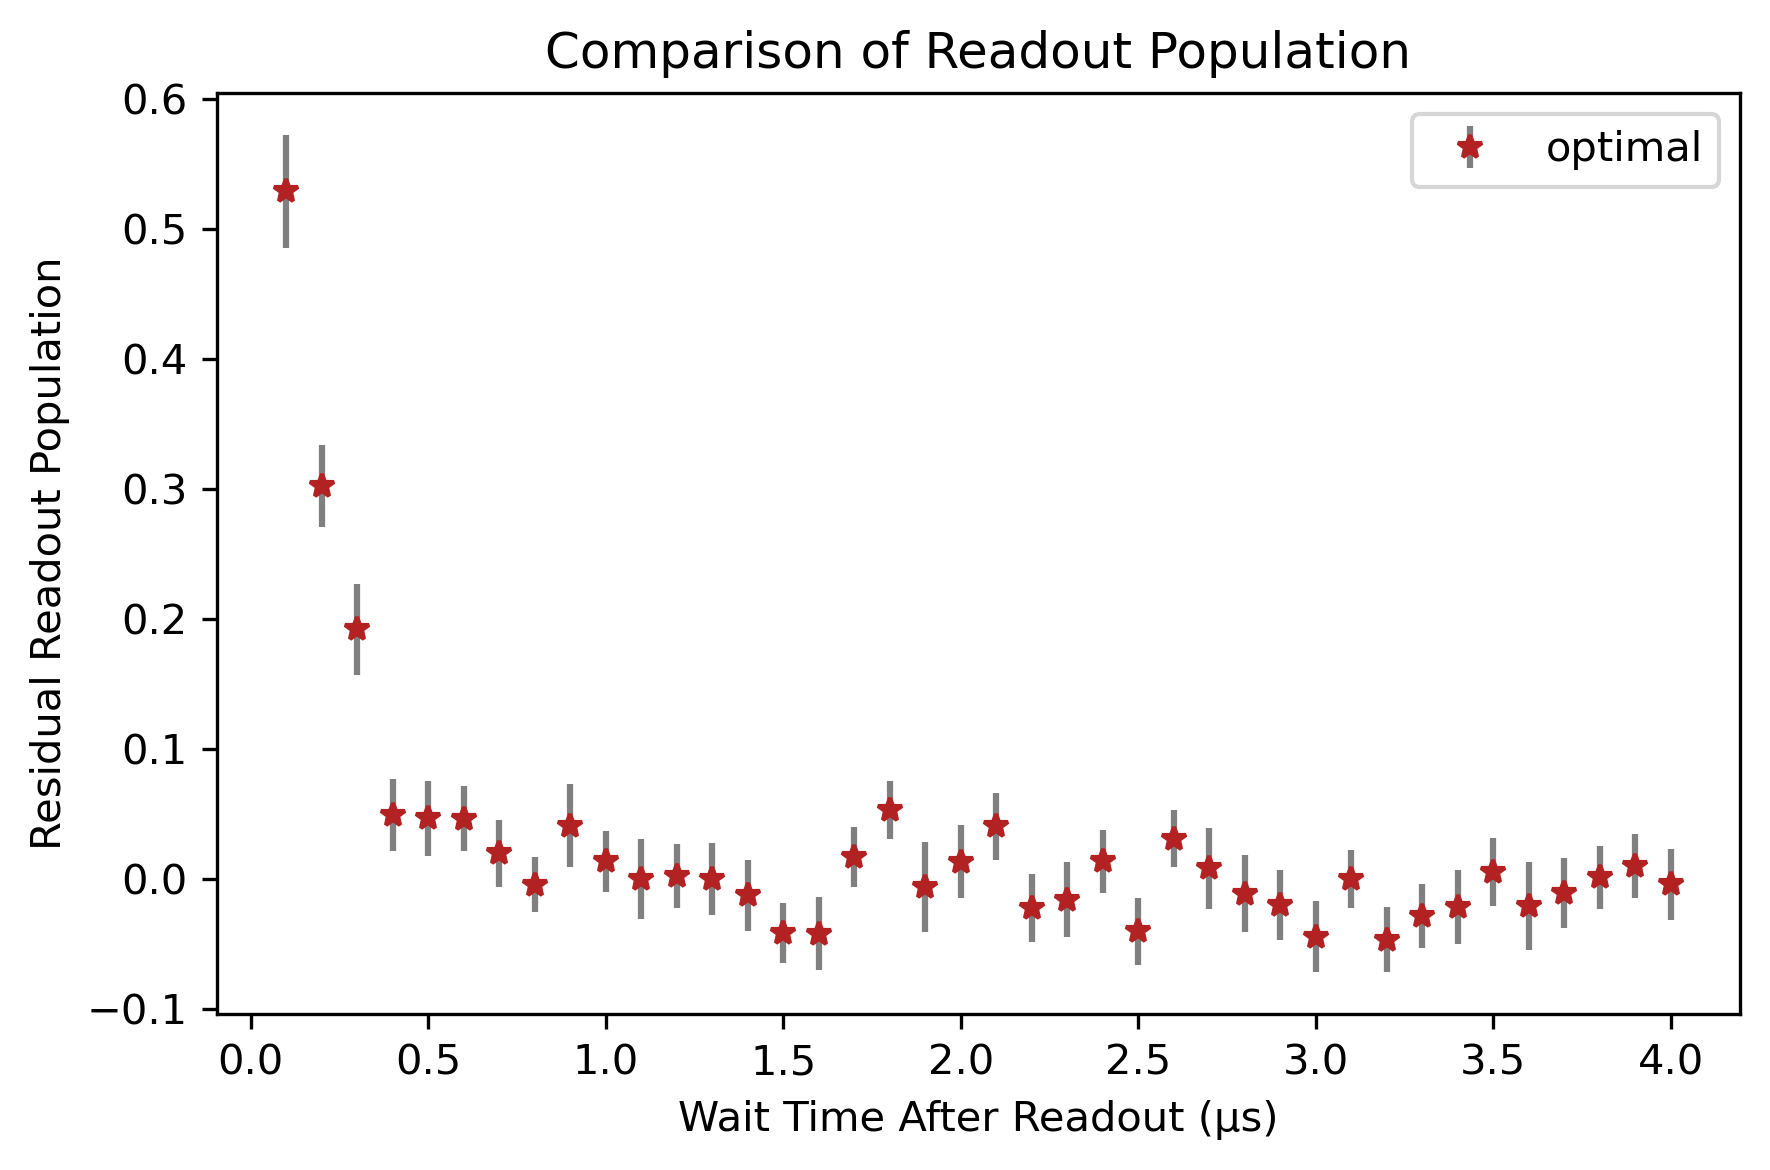

In [298]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data)
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))

fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

# ax1.errorbar(wait_times_sq*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
#              ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')

ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
# ax1.set_ylim(-.1, 1)
# ax2.set_ylim(-.1, 1)
# plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

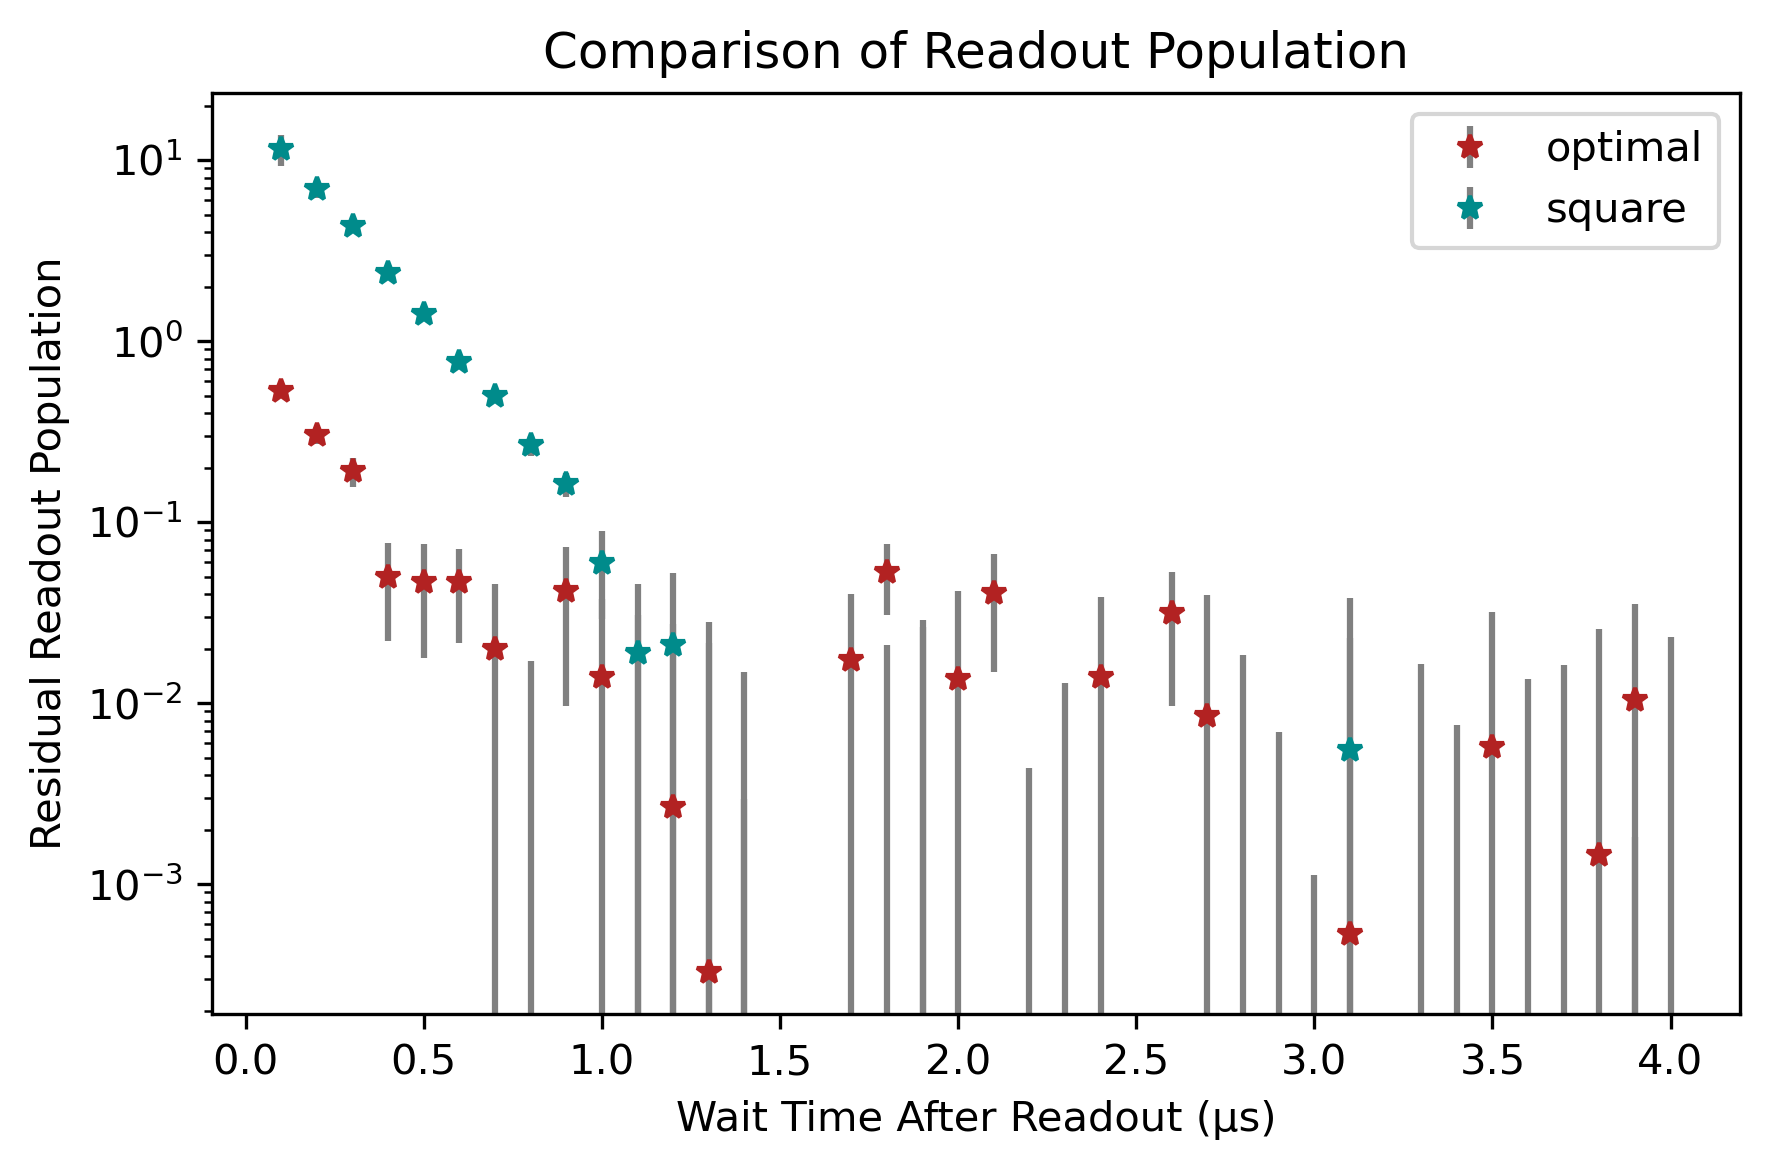

In [304]:
read_popt_opt = []
read_popt_error_opt = []
for j in range(len(wait_times_opt)):
    y_data = i_cal_opt.iloc[j]
    x_data = ramsey_times_opt
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data, y_data)
    read_popt_opt.append(popt[0])
    read_popt_error_opt.append(np.sqrt(np.diag(pcov)[0]))
    
read_popt_square = []
read_popt_error_square = []
for j in range(len(wait_times_sq)):
    y_data = i_cal_sq.iloc[j]
    x_data = ramsey_times_sq
    popt, pcov = scipy.optimize.curve_fit(ramsfit, x_data[2:], y_data[2:])
    read_popt_square.append(popt[0])
    read_popt_error_square.append(np.sqrt(np.diag(pcov)[0]))


fig, ax1  = plt.subplots(dpi=300)
 
ax1.errorbar(wait_times_opt*1e6, read_popt_opt, yerr = read_popt_error_opt, fmt='*', color='firebrick', 
             ecolor='grey', capthick=2, label='optimal')

ax1.errorbar(wait_times_sq*1e6, read_popt_square, yerr = read_popt_error_square, fmt='*', color='darkcyan',
             ecolor='grey', capthick=2, label = 'square')
# ax2.tick_params(axis='y', labelcolor='darkcyan')

ax1.set_title('Comparison of Readout Population')
ax1.set_ylabel('Residual Readout Population')
ax1.set_xlabel('Wait Time After Readout (μs)')
# ax1.set_ylim(-.1, 1)
# ax2.set_ylim(-.1, 1)
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('../plots/Readout_Popt_Comp_talk_full.pdf')
plt.show()

In [145]:
10*np.exp(-1.6/0.18)

0.0013791280933656194

[17.72802758  0.19170389  0.25202151] [0.6441008  0.00782116 0.06847254]


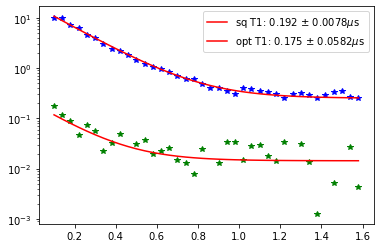

[0.18366301 0.17469616 0.01440297] [0.08260954 0.05822461 0.00342279]


In [146]:
y = np.array(read_popt_square)
x = np.array(wait_times)*1e6

plt.plot(x, y, 'b*')
popt, pcov = scipy.optimize.curve_fit(expfunc_baseline, x, y)
print(popt, np.sqrt(np.diag(pcov)))
plt.plot(x, expfunc_baseline(x, popt[0], popt[1], popt[2]), 'r-', 
         label=r'sq T1: %.3f $\pm$ %.4f$\mu$s'%(popt[1], np.sqrt(np.diag(pcov))[1]))
y = np.array(read_popt_opt)
x = np.array(wait_times)*1e6

plt.plot(x, y, 'g*')
popt, pcov = scipy.optimize.curve_fit(expfunc_baseline, x[2:], y[2:])
plt.plot(x, expfunc_baseline(x, popt[0], popt[1], popt[2]), 'r-', 
         label=r'opt T1: %.3f $\pm$ %.4f$\mu$s'%(popt[1], np.sqrt(np.diag(pcov))[1]))
plt.legend()
plt.yscale('log')
plt.show()
print(popt, np.sqrt(np.diag(pcov)))

0.003333333333333333 0.0007380739030881347
Chi:  0.3804 MHz
Kappa:  0.9149659090909091 MHz
Cavity Occupation 0.00142
Cavity temperature = 53.37698929287676 mK
Cavity temperature+ = 55.03127983687904 mK
Cavity temperature- = 51.37911894753762 mK


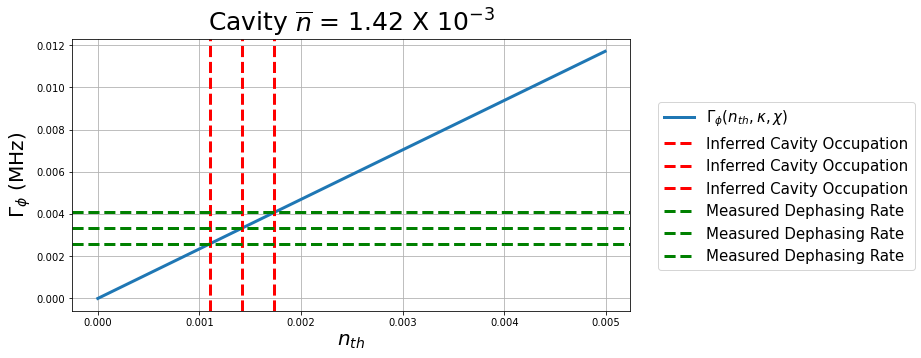

In [474]:
T2 = 120
T2err = 10
T1 = 100
T1err = 10

gph  = 1/(T2) - 1/(2*T1)
gpherr = sqrt( (1/(2*T1))**4*T1err**2 + (1/(T2))**4*T2err**2 )

print (gph, gpherr)

nu_r = 8.0517
Q = 8800.0
kappa = 2*pi*nu_r/Q*1e3

chi = 0.3804*2*pi

print ("Chi: ", chi/(2*pi), "MHz")
print ("Kappa: ", kappa/(2*pi), "MHz")

def temperature_cav(nu,mean_n):
    Kb = 1.38e-23
    h = 6e-34
    return h*nu/(Kb*log((1+mean_n)/mean_n))

def occupation_cav(nu,T):
    Kb = 1.38e-23
    h = 6e-34
    T = T*1e-3
    return 1/(exp(h*nu/(Kb*T))-1)


def dephasing(kappa,chi,nth):
    return kappa/2.0*real(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa)-1)

def freq_shift(kappa,chi,nth):
    return kappa/2.0*imag(sqrt((1+2*1j*chi/kappa)**2 + ((8*1j*chi*nth))/kappa))

figure(figsize=(10,5))
subplot(111)
n_th = arange(0.0, 0.005,0.00001)

plot(n_th, array([dephasing(kappa,chi,n) for n in n_th] ), label = '$\Gamma_{\phi}(n_{th}, \kappa, \chi)$', linewidth=3)

n_cav = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - gph))]
n_cav_pluserr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph+gpherr)))]
n_cav_negerr = n_th[argmin(abs(array([dephasing(kappa,chi,n) for n in n_th]) - (gph-gpherr)))]
print ("Cavity Occupation", n_cav)

axvline(n_cav,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_pluserr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)
axvline(n_cav_negerr,linestyle='dashed', label="Inferred Cavity Occupation",color='r', linewidth=3)

axhline(gph,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph+gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)
axhline(gph-gpherr,linestyle='dashed', label="Measured Dephasing Rate",color='g', linewidth=3)

ylabel('$\Gamma_{\phi}$ (MHz)', fontsize='20')
xlabel('$n_{th}$', fontsize='20')
title('Cavity $\overline{n}$ = %s X $10^{-3}$' %(n_cav*1e3), fontsize='25')
grid()
legend(loc=(1.05, 0.15),fontsize='15')
print ("Cavity temperature = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav)))
print ("Cavity temperature+ = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_pluserr)))
print ("Cavity temperature- = %s mK"%(1e3*temperature_cav(nu_r*1e9,n_cav_negerr)))